## Devlog

#### 20/06/23  
Quise usar la funcion hmm.GaussianHMM. Sin embargo, hay un issue con el startprob_prior:
>ValueError                                Traceback (most recent call last)  
>ValueError: startprob_ must sum to 1 (got nan)

Esta issue esta trackeada acá ("Looks like there is some issue...")
https://stackoverflow.com/questions/18796658/scikit-learn-gaussian-hmm-valueerror-startprob-must-sum-to-1-0
pero pide modificar el paquete hmm.base para hacer un quickfix de un -1.0 que quedó en el código. Voy a buscar de solucionar esto con el paquete estándar.   
Por lo tanto, no voy a usar el parámetro startprob_prior.

## Startup

Hidden Markov Models With Python (Gold example)  
https://medium.com/@natsunoyuki/hidden-markov-models-with-python-c026f778dfa7  
## 
   
  
Bloomberg: A PRACTICAL MODEL FOR PREDICTION OF INTRADAY VOLATILITY  
https://assets.bbhub.io/professional/sites/10/intraday_volatility-3.pdf?bbgsum-page=DG-WS-PROF-BLOG-POST-121973&tactic-page=429888

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
from hmmlearn import hmm

import os
import pickle

In [2]:
import yfinance as yf
yf.pdr_override()

In [28]:
np.random.seed(42)

In [29]:
dataroute=os.path.join("..",  "data")
resultsroute=os.path.join("..",  "results")

## Data Retrieval

In [4]:
tickerlist=["^MERV", 
            "GGAL", "GGAL.BA", 
            "YPF", "YPFD.BA",
            "EDN", "EDN.BA",
            "BMA", "BMA.BA"] 
# sumar tamb BBAR/BBAR? TEO/TECO2?

In [5]:
factordict={"GGAL": 10, "YPF":1, "EDN":20, "BMA":10, "BBAR":3, "TEO":5}

In [6]:
stocks=tickerlist.copy()
stocks.remove("^MERV")
stocklist=[]

for i in range(0, len(stocks), 2):
    stocklist.append((stocks[i], stocks[i+1]))
del stocks
stocklist

[('GGAL', 'GGAL.BA'), ('YPF', 'YPFD.BA'), ('EDN', 'EDN.BA'), ('BMA', 'BMA.BA')]

In [7]:
ohlclist=["Open", "High", "Low", "Close"]

In [8]:
objectlist=[]

for ticker in tickerlist:
    objectlist.append(yf.Ticker(ticker))    

In [9]:
# get historical market data
data={}
start='2013-01-01'
end="2023-06-01"

In [10]:
name=f'dataset_{start}_{end}_{str(tickerlist)}.pickle'
filename=os.path.join(dataroute, name)

In [11]:
if not os.path.exists(filename):
    for ticker in objectlist:
        # descargo data en un diccionario[ticker]
        data[ticker.ticker] = ticker.history(start=start, end=end)
        # guardo en un pickle
    with open(filename, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
else:
    with open(filename, 'rb') as handle:
        data=pickle.load(handle)

## Data quality deletion

In [12]:
data_quality_dates=["2022-07-14"]

In [13]:
for ticker in tickerlist:
    data[ticker]=data[ticker].loc[~data[ticker].index.isin(pd.to_datetime(data_quality_dates))]

## Implicit USD calculation

In [14]:
def _reindex_refill_dfs(df1, df2):
    """
    The function returns two dataframes with an index as the union of the two.
    The dataframes are then forward filled.
    """
    index3=df1.index.union(df2.index)
    # reindex both con index3
    df3=df1.reindex(index3)
    df4=df2.reindex(index3)
    # fillna con previous value
    df3.fillna(method="ffill")
    df4.fillna(method="ffill")
    return df3, df4

In [15]:
def calculate_usd(usd_df, ars_df, conversion_factor):
    """
    The function returns a dataframe with an index the size of the union between the two.
    Missing values in dates (stemming from, for example, holidays in one country) are
    forward filled to create the last  
    """
    usd_df_r, ars_df_r = _reindex_refill_dfs(usd_df, ars_df)
    implicit_usd = ars_df_r.divide(usd_df_r)*conversion_factor
    return implicit_usd

In [16]:
usdlist=[]
for stocktuplo in stocklist:
    us, ba = stocktuplo
    usdlist.append(f"USD_{us}")
    data[f"USD_{us}"]=calculate_usd(data[us][ohlclist], data[ba][ohlclist], factordict[us])
    data[f"USD_{us}"]["Average"]=data[f"USD_{us}"].mean(axis=1)

In [17]:
data["USD"]=pd.DataFrame(columns=ohlclist)

for i in ohlclist:
    df=pd.concat([data[col][i] for col in usdlist], axis=1)
    data["USD"][i]=df.mean(axis=1)
    
data["USD"]["Average"]=data["USD"].mean(axis=1)

In [18]:
for key in data.keys():
    data[key].fillna(method="ffill", inplace=True)
    # revisar esto

<AxesSubplot:xlabel='Date'>

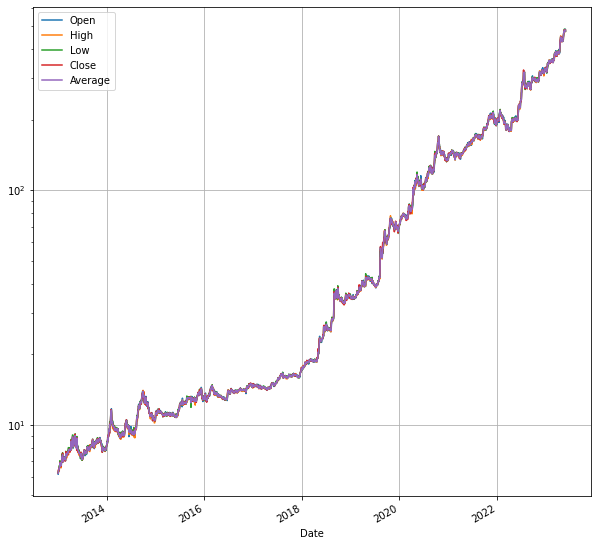

In [19]:
data["USD"][[*ohlclist, "Average"]].plot(figsize=(10,10), logy=True, grid=True)

## USD Denominated Index

In [20]:
data["USD_^MERV"]=pd.DataFrame(columns=ohlclist)

for col in ohlclist:
    data["USD_^MERV"][col] = data["^MERV"][col]/data["USD"]["Average"]

In [21]:
data["USD_^MERV"].fillna(method="ffill", inplace=True)

## Intraday Volatility

Vamos a usar para medir intraday volatility el estimador de Garman and Klass (1980):

$$V_{ohlc}=0.5*[log(H)-log(L)]^2+(2*log(2)-1)*[log(C)-log(O)]^2$$ 
Donde H es el precio mas alto del día, L el bajo, C el cierre y O su apertura

Garman, M. B. and M. J. Klass (1980). On the estimation of security price volatilities from historical data. Journal of Business 53, 67–78.

In [22]:
def gk_vol(o, h, l, c):
    "Returns Garman Klass (1980) intraday volatility estimator"
    return 0.5*(np.log(h)-np.log(l))**2+(2*np.log(2)-1)*(np.log(c)-np.log(o))**2

## Returns Calculation

In [23]:
for ticker in data.keys():
    view=data[ticker]
    view["rets"] = view["Close"]/view["Close"].shift()-1
    view["log_rets"] = np.log(view["Close"]/view["Close"].shift())
    view["norm_range"] = (view["High"]-view["High"])/view["Open"]
    # chequear si esto tiene asidero
    # alternativa (view["High"]-view["High"])/view["Close"]
    view["gk_vol"] = gk_vol(o=view["Open"], h=view["High"], l=view["Low"], c=view["Close"])
    # delete first observation to eliminate nans
    data[ticker]=data[ticker][1:].copy()

## Descriptive Statistics

In [24]:
# TBD

## HMM Training

In [74]:
X=data["GGAL"][datacols].values.reshape(-1, len(datacols))
comps=3
model=hmm.GMMHMM(n_components=comps,
                 startprob_prior=np.repeat(1/comps, comps),#flat prior
                 verbose=True,
                 covariance_type="diag",
                 n_iter=100)
model.fit(X)

         1   11151.41642116             +nan
         2   17707.53340918   +6556.11698802
         3   19556.44284908   +1848.90943991
         4   19832.12390546    +275.68105638
         5   19950.98307578    +118.85917033
         6   20006.61983806     +55.63676228
         7   20041.23790944     +34.61807138
         8   20062.51722478     +21.27931534
         9   20074.95020939     +12.43298461
        10   20082.18502636      +7.23481697
        11   20086.56105161      +4.37602525
        12   20089.34472305      +2.78367144
        13   20091.19248758      +1.84776453
        14   20092.45640124      +1.26391367
        15   20093.33746054      +0.88105930
        16   20093.95820473      +0.62074419
        17   20094.39772649      +0.43952176
        18   20094.70935067      +0.31162417
        19   20094.93010985      +0.22075918
        20   20095.08618176      +0.15607191
        21   20095.19623619      +0.11005443
        22   20095.27362832      +0.07739213
        23

GMMHMM(covars_prior=array([[[-1.5, -1.5]],

       [[-1.5, -1.5]],

       [[-1.5, -1.5]]]),
       covars_weight=array([[[0., 0.]],

       [[0., 0.]],

       [[0., 0.]]]),
       means_prior=array([[[0., 0.]],

       [[0., 0.]],

       [[0., 0.]]]),
       means_weight=array([[0.],
       [0.],
       [0.]]), n_components=3,
       n_iter=100, startprob_prior=array([0.33333333, 0.33333333, 0.33333333]),
       verbose=True, weights_prior=array([[1.],
       [1.],
       [1.]]))

In [62]:
model.predict(X)

Degenerate mixture covariance


array([2, 0, 0, ..., 0, 0, 0], dtype=int64)

In [70]:
np.repeat(1/comp, comp).sum()

1.0

In [73]:
import sys
sys.path

['C:\\Users\\Alfred\\PycharmProjects\\tesis_MS_hmm\\regime-switching-hmm\\notebooks',
 'C:\\Users\\Alfred\\Anaconda3\\envs\\pythonforfinance\\python37.zip',
 'C:\\Users\\Alfred\\Anaconda3\\envs\\pythonforfinance\\DLLs',
 'C:\\Users\\Alfred\\Anaconda3\\envs\\pythonforfinance\\lib',
 'C:\\Users\\Alfred\\Anaconda3\\envs\\pythonforfinance',
 '',
 'C:\\Users\\Alfred\\AppData\\Roaming\\Python\\Python37\\site-packages',
 'C:\\Users\\Alfred\\Anaconda3\\envs\\pythonforfinance\\lib\\site-packages',
 'C:\\Users\\Alfred\\Anaconda3\\envs\\pythonforfinance\\lib\\site-packages\\win32',
 'C:\\Users\\Alfred\\Anaconda3\\envs\\pythonforfinance\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\Alfred\\Anaconda3\\envs\\pythonforfinance\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\Alfred\\Anaconda3\\envs\\pythonforfinance\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\Alfred\\.ipython']

In [76]:
models={}
comps=[2,3,4]
datacols=["log_rets","gk_vol"]

for key in data.keys():
    print(key)
    for comp in comps:
        print(comp)
        modelname=f"{key}_{comp}_model"
        predictionname=f"{key}_{comp}_prediction"
        
        X = data[key][datacols].values.reshape(-1, len(datacols))
        # bivariate
        # log returns and intraday volatility        
        models[modelname]=hmm.GaussianHMM(n_components = comp, #no voy a usar startprob_prior por devlog 20-06-23
                                          covariance_type = "diag", 
                                          n_iter = 50,
                                          random_state = 42)
        models[modelname].fit(X)
        models[predictionname]=models[modelname].predict(X)

Model is not converging.  Current: 18846.402754161056 is not greater than 18847.998483644085. Delta is -1.5957294830295723
Model is not converging.  Current: 18117.796692761738 is not greater than 18117.797476097858. Delta is -0.0007833361196389887


^MERV
2
priorsum 1.0
2  complete
3
priorsum 1.0
3  complete
4
priorsum 1.0


Model is not converging.  Current: 18038.271664667773 is not greater than 18038.294935018097. Delta is -0.02327035032431013


4  complete
GGAL
2
priorsum 1.0
2  complete
3
priorsum 1.0


Model is not converging.  Current: 18050.971305488103 is not greater than 18055.266202050603. Delta is -4.294896562500071


3  complete
4
priorsum 1.0
4  complete
GGAL.BA
2
priorsum 1.0
2  complete
3
priorsum 1.0


Model is not converging.  Current: 17150.086480979455 is not greater than 17150.455210098415. Delta is -0.3687291189598909
Model is not converging.  Current: 17766.547958740026 is not greater than 17767.336447612863. Delta is -0.7884888728367514
Model is not converging.  Current: 18304.566025650853 is not greater than 18308.530325076103. Delta is -3.9642994252499193


3  complete
4
priorsum 1.0
4  complete
YPF
2
priorsum 1.0


Model is not converging.  Current: 17756.698081311817 is not greater than 17758.102920394307. Delta is -1.4048390824900707
Model is not converging.  Current: 18379.909071649763 is not greater than 18381.389044583793. Delta is -1.4799729340302292


2  complete
3
priorsum 1.0
3  complete
4
priorsum 1.0
4  complete
YPFD.BA
2
priorsum 1.0


Model is not converging.  Current: 17799.15803182742 is not greater than 17801.33579652084. Delta is -2.177764693420613


2  complete
3
priorsum 1.0


Model is not converging.  Current: 17830.6386048777 is not greater than 17832.104640020898. Delta is -1.4660351431994059


3  complete
4
priorsum 1.0
4  complete
EDN
2
priorsum 1.0
2  complete
3
priorsum 1.0
3  complete
4
priorsum 1.0


Model is not converging.  Current: 17102.724699100654 is not greater than 17103.965930608116. Delta is -1.2412315074616345


4  complete
EDN.BA
2
priorsum 1.0
2  complete
3
priorsum 1.0
3  complete
4
priorsum 1.0


Model is not converging.  Current: 17947.5845266519 is not greater than 17950.410638957204. Delta is -2.826112305305287


4  complete
BMA
2
priorsum 1.0
2  complete
3
priorsum 1.0


Model is not converging.  Current: 18019.71971784343 is not greater than 18026.017377264732. Delta is -6.297659421303251
Model is not converging.  Current: 17316.42508604387 is not greater than 17316.502682073187. Delta is -0.07759602931764675


3  complete
4
priorsum 1.0
4  complete
BMA.BA
2
priorsum 1.0
2  complete
3
priorsum 1.0


Model is not converging.  Current: 16813.933078785383 is not greater than 16816.729702928853. Delta is -2.7966241434696713
Model is not converging.  Current: 17407.676466399498 is not greater than 17410.711841601034. Delta is -3.035375201536226
Model is not converging.  Current: 21249.300456161553 is not greater than 21251.83043896897. Delta is -2.5299828074166726


3  complete
4
priorsum 1.0
4  complete
USD_GGAL
2
priorsum 1.0
2  complete
3
priorsum 1.0


Model is not converging.  Current: 20431.373826363364 is not greater than 20431.376327309. Delta is -0.002500945636711549
Model is not converging.  Current: 21252.294419279937 is not greater than 21253.560625704333. Delta is -1.2662064243959321


3  complete
4
priorsum 1.0
4  complete
USD_YPF
2
priorsum 1.0
2  complete
3
priorsum 1.0


Model is not converging.  Current: 21258.894740493193 is not greater than 21259.214222304214. Delta is -0.3194818110205233
Model is not converging.  Current: 19728.3114473762 is not greater than 19729.962409520325. Delta is -1.650962144125515


3  complete
4
priorsum 1.0
4  complete
USD_EDN
2
priorsum 1.0
2  complete
3
priorsum 1.0


Model is not converging.  Current: 19702.018017919552 is not greater than 19709.44554490591. Delta is -7.427526986357407
Model is not converging.  Current: 21090.923443575575 is not greater than 21091.601887824643. Delta is -0.6784442490679794


3  complete
4
priorsum 1.0
4  complete
USD_BMA
2
priorsum 1.0
2  complete
3
priorsum 1.0


Model is not converging.  Current: 20256.93497799784 is not greater than 20257.624646317854. Delta is -0.6896683200138796
Model is not converging.  Current: 21093.233462400352 is not greater than 21093.963463538155. Delta is -0.7300011378029012


3  complete
4
priorsum 1.0
4  complete
USD
2
priorsum 1.0
2  complete
3
priorsum 1.0
3  complete
4
priorsum 1.0


Model is not converging.  Current: 19947.354419836363 is not greater than 19948.459798279575. Delta is -1.1053784432115208
Model is not converging.  Current: 19214.81375827267 is not greater than 19214.816078718475. Delta is -0.00232044580479851


4  complete
USD_^MERV
2
priorsum 1.0
2  complete
3
priorsum 1.0
3  complete
4
priorsum 1.0


Model is not converging.  Current: 20005.693900035138 is not greater than 20006.559117908284. Delta is -0.8652178731463209


4  complete


In [77]:
# Predict the hidden states corresponding to observed X.
for key in data.keys():
    for comp in comps:
        print(">"*30, key)
        model=models[f"{key}_{comp}_model"]
        prediction=models[f"{key}_{comp}_prediction"]
        print("unique states: ", pd.unique(prediction))
        print("\nStart probabilities:")
        print(model.startprob_)
        print("\nTransition matrix:")
        print(model.transmat_)
        print("\nGaussian distribution means:")
        print(model.means_)
        print("\nGaussian distribution covariances:")
        print(model.covars_)
        print()

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> ^MERV
unique states:  [0 1]

Start probabilities:
[9.99999994e-01 5.77413223e-09]

Transition matrix:
[[0.9918672  0.0081328 ]
 [0.64151059 0.35848941]]

Gaussian distribution means:
[[ 0.00236655  0.00062066]
 [-0.03622866  0.01457542]]

Gaussian distribution covariances:
[[[4.65039638e-04 0.00000000e+00]
  [0.00000000e+00 4.63109865e-06]]

 [[1.43961566e-02 0.00000000e+00]
  [0.00000000e+00 1.50141259e-03]]]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> ^MERV
unique states:  [0 1 2]

Start probabilities:
[9.76056293e-01 2.39437071e-02 1.84779933e-78]

Transition matrix:
[[2.69026944e-03 9.93667700e-01 3.64203088e-03]
 [9.71594917e-01 2.01031706e-02 8.30191288e-03]
 [2.03692543e-01 7.96307457e-01 4.89648707e-22]]

Gaussian distribution means:
[[ 0.00290558  0.00059355]
 [ 0.00205049  0.00071539]
 [-0.09642094  0.02416001]]

Gaussian distribution covariances:
[[[4.26096031e-04 0.00000000e+00]
  [0.00000000e+00 8.67280813e-06]]

 [[5.78363879e-04 0.00000000e+00]
  [0.00

In [78]:
def plot_close_rets_vol(data, key, comp):
    model=models[f"{key}_{comp}_model"]
    prediction=models[f"{key}_{comp}_prediction"]
    states=set(prediction)

    plt.figure(figsize = (20, 20))

    for subplot, var in zip(range(1,4), ["Close", "log_rets", "gk_vol"]):    
        plt.subplot(3,1,subplot)
        for i in set(prediction):
            state = (prediction == i)
            x = data[key].index[state]
            y = data[key][var].iloc[state]
            plt.plot(x, y, '.')
        plt.legend(states, fontsize=16)
        plt.grid(True)
        plt.xlabel("datetime", fontsize=16)
        plt.ylabel(var, fontsize=16)

    plt.savefig(os.path.join(resultsroute, "graphs", 
                             f"{comp}_states", 
                             f"{key}_model_{comp}.png"))

C:\Users\Alfred\Anaconda3\envs\pythonforfinance\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


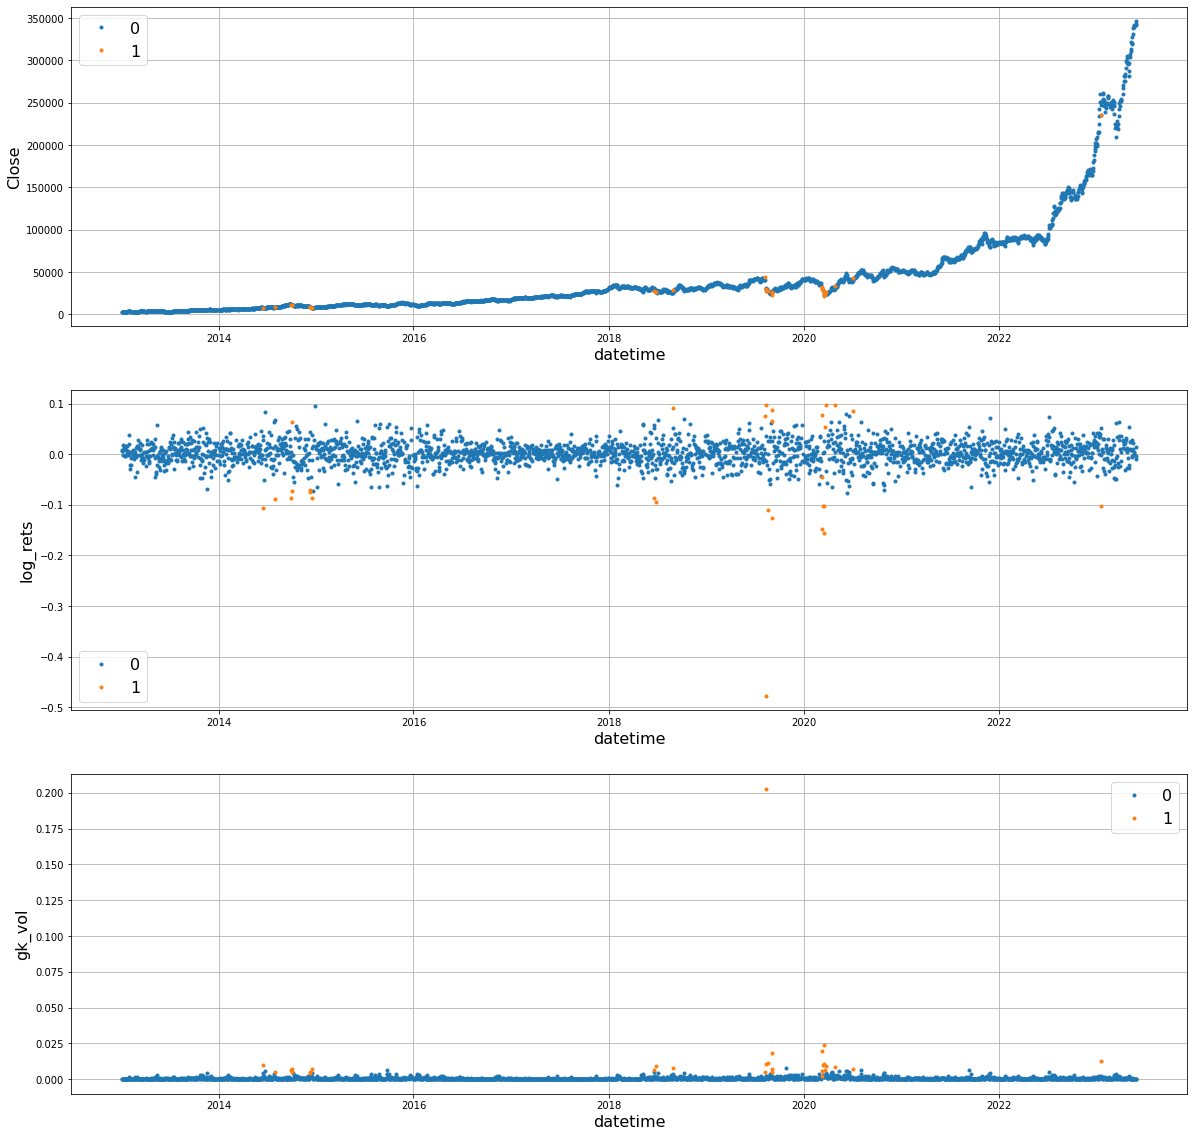

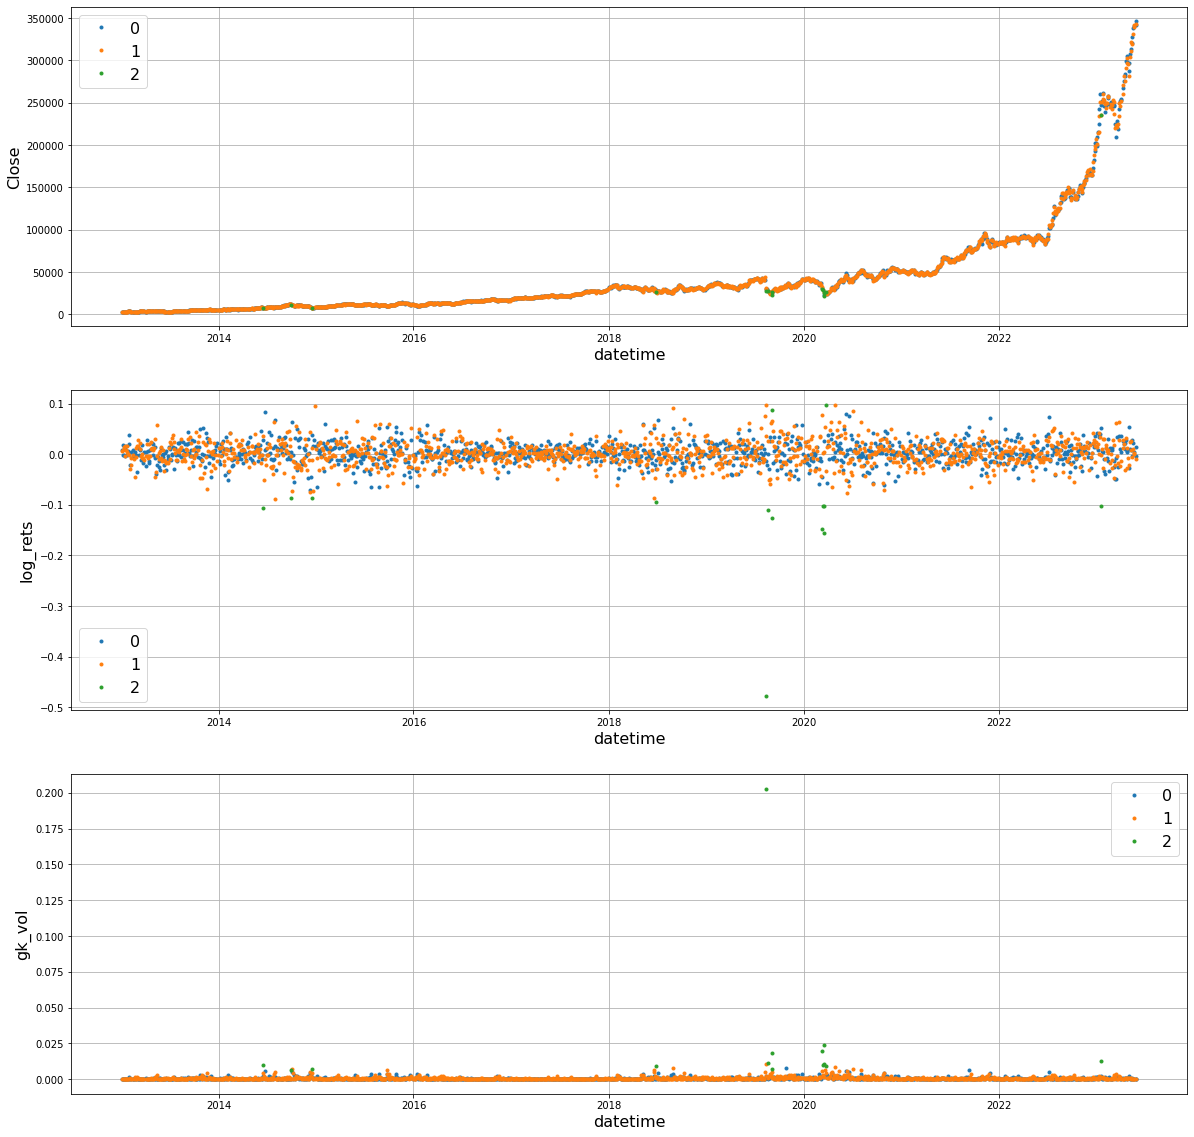

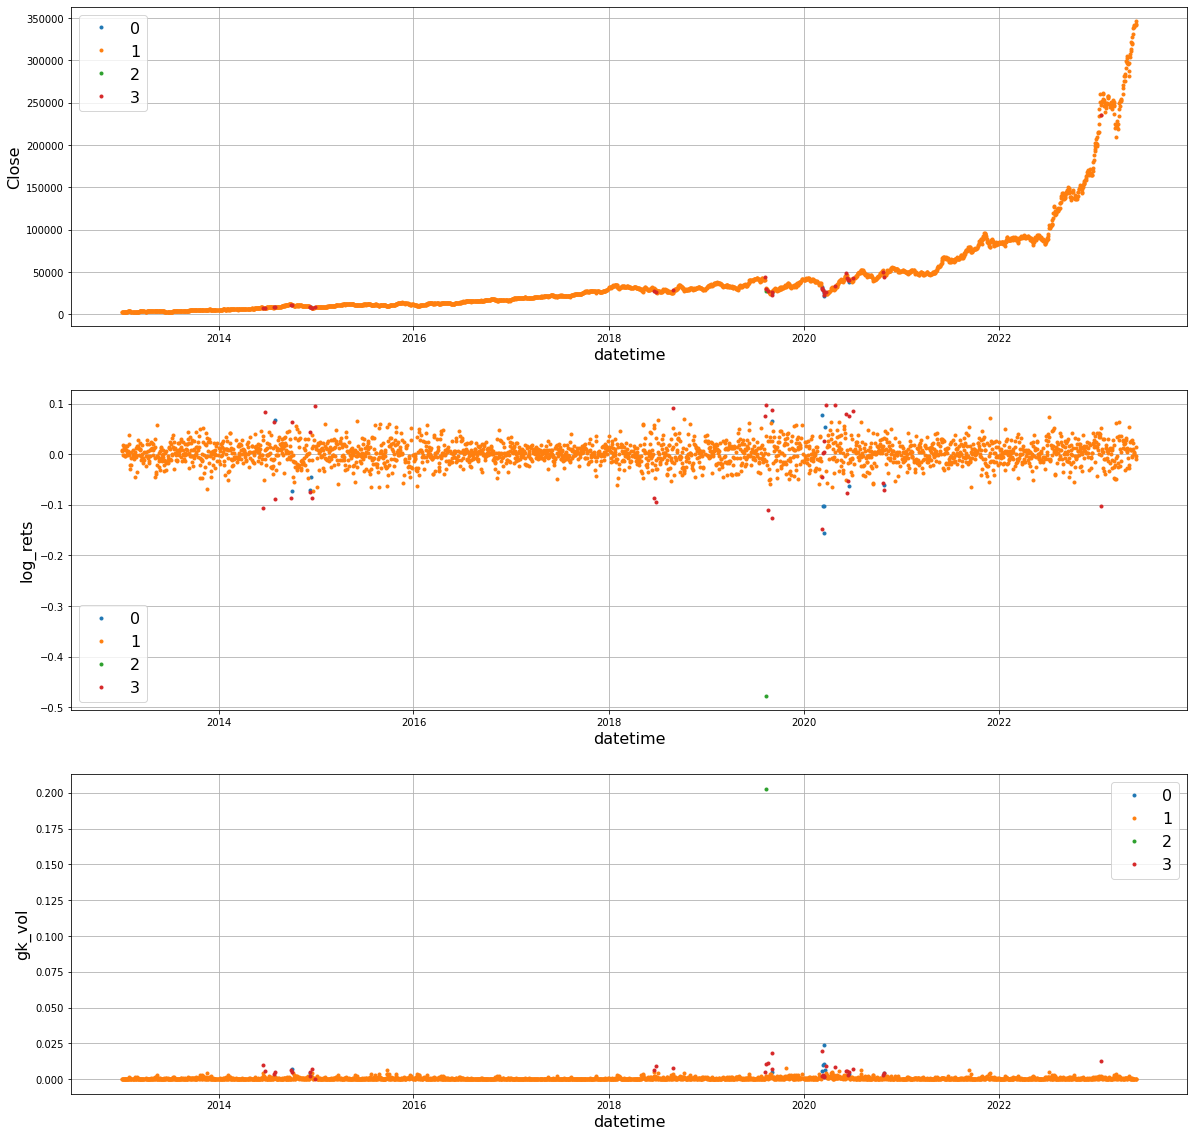

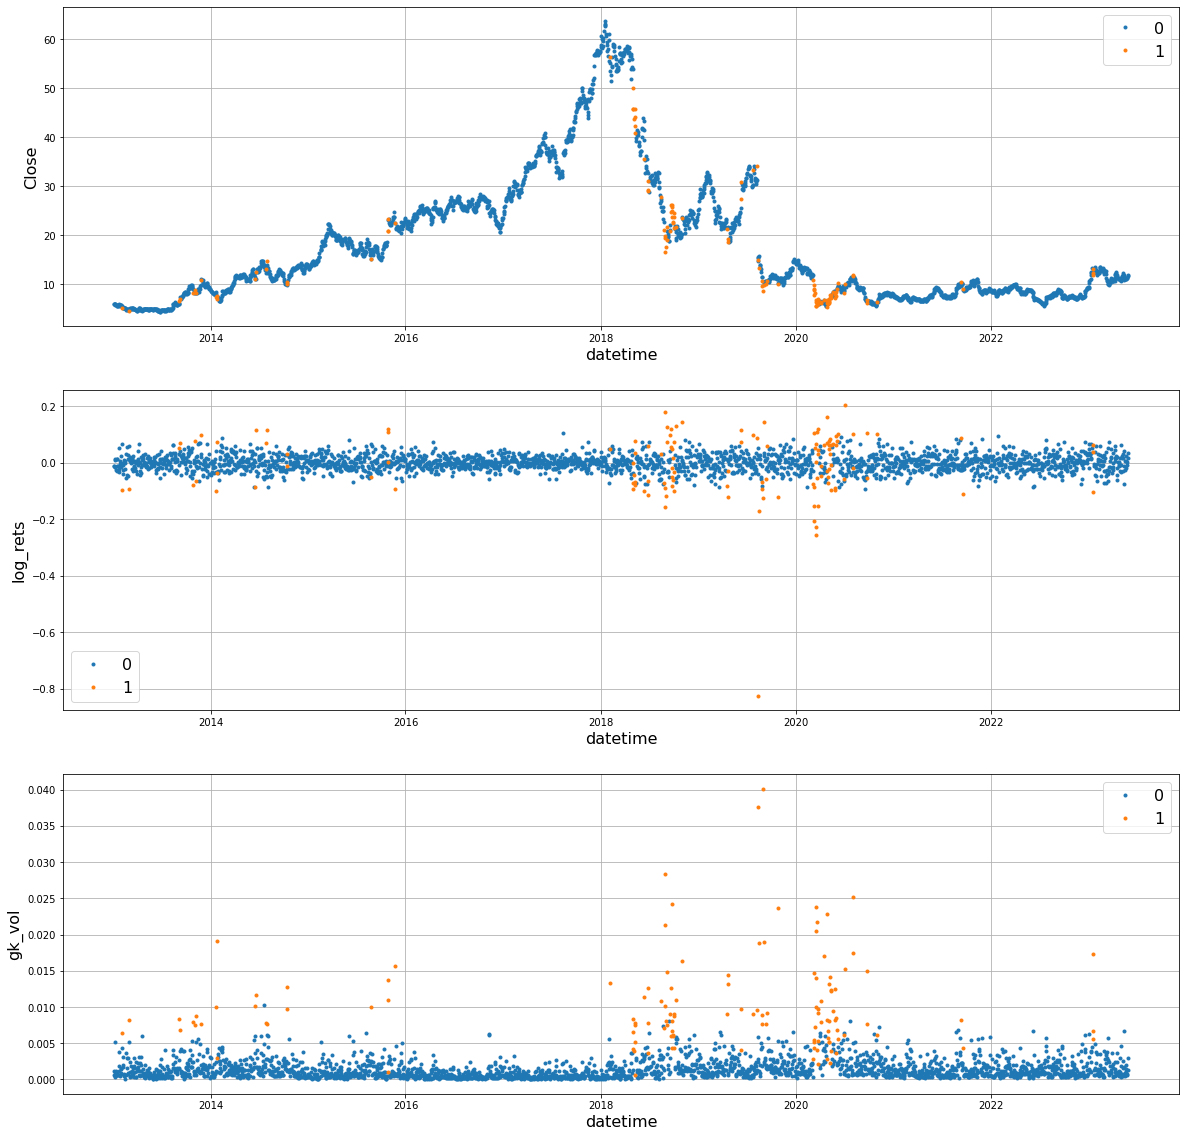

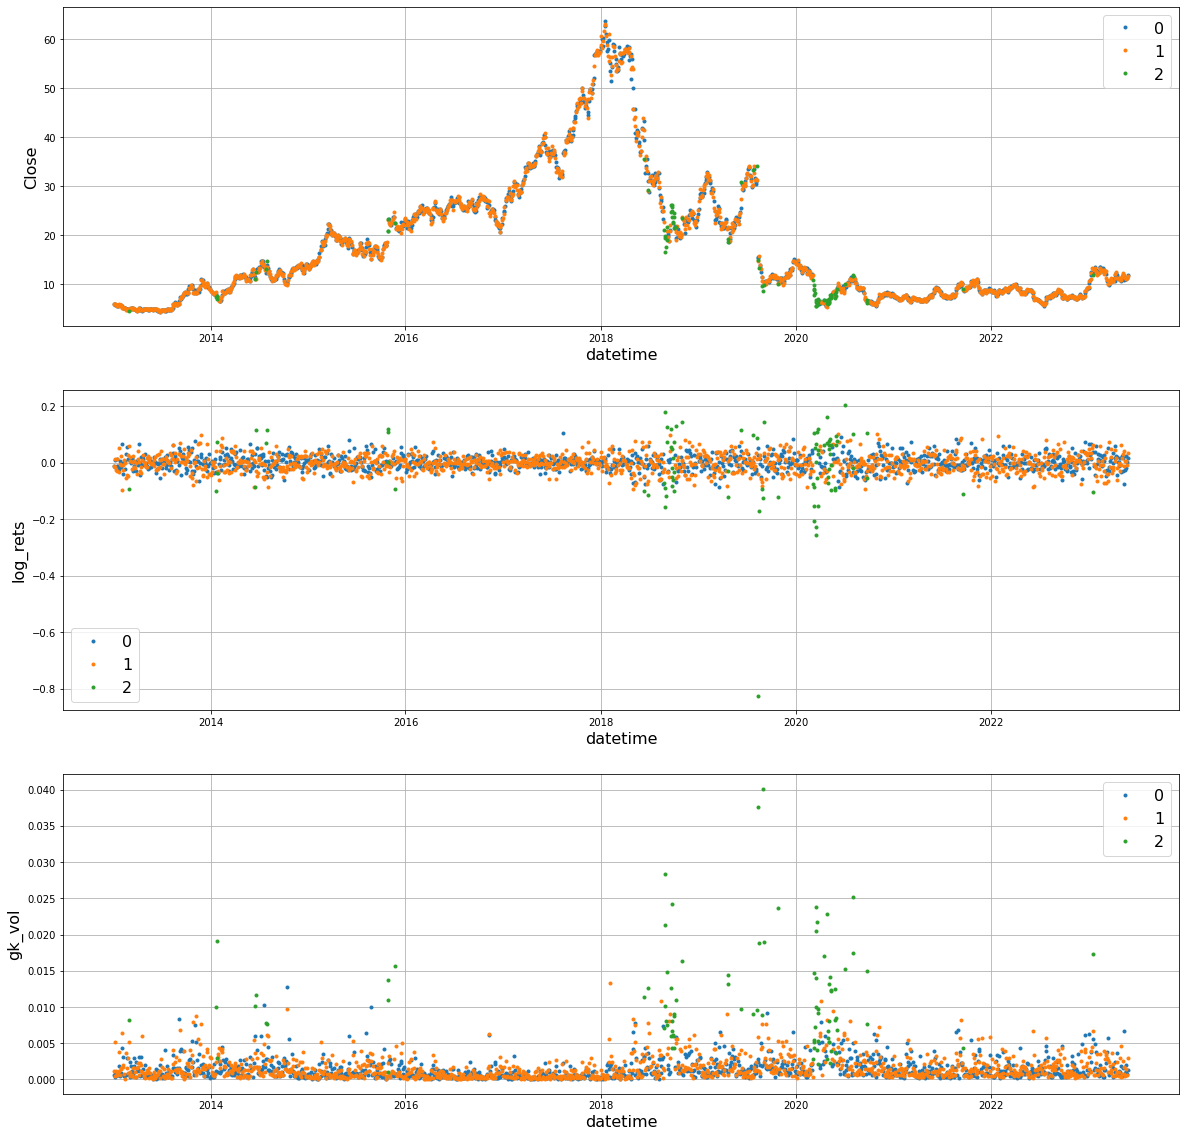

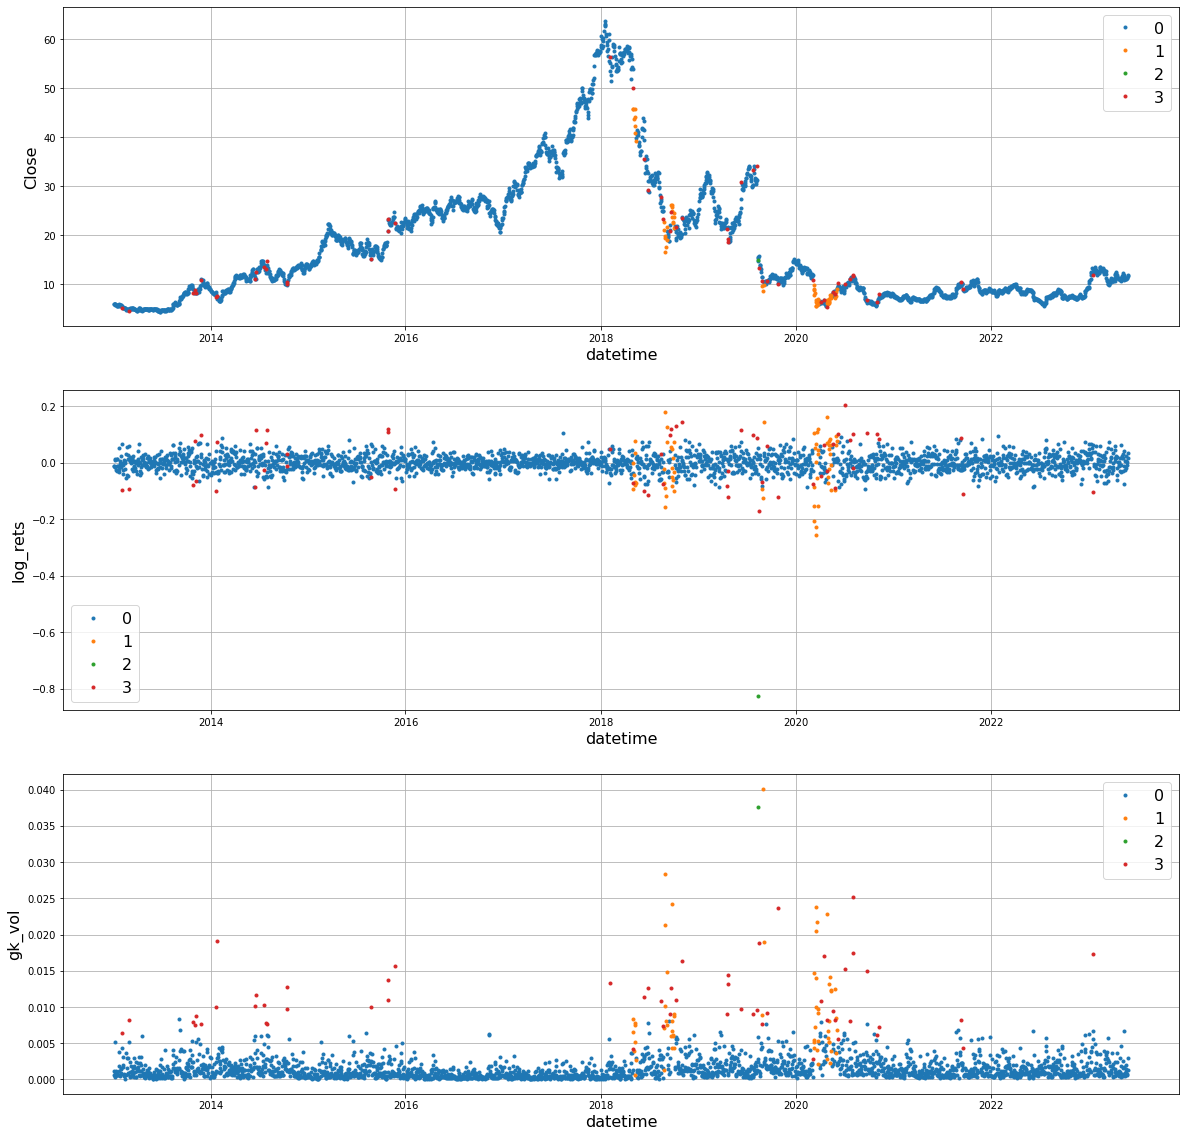

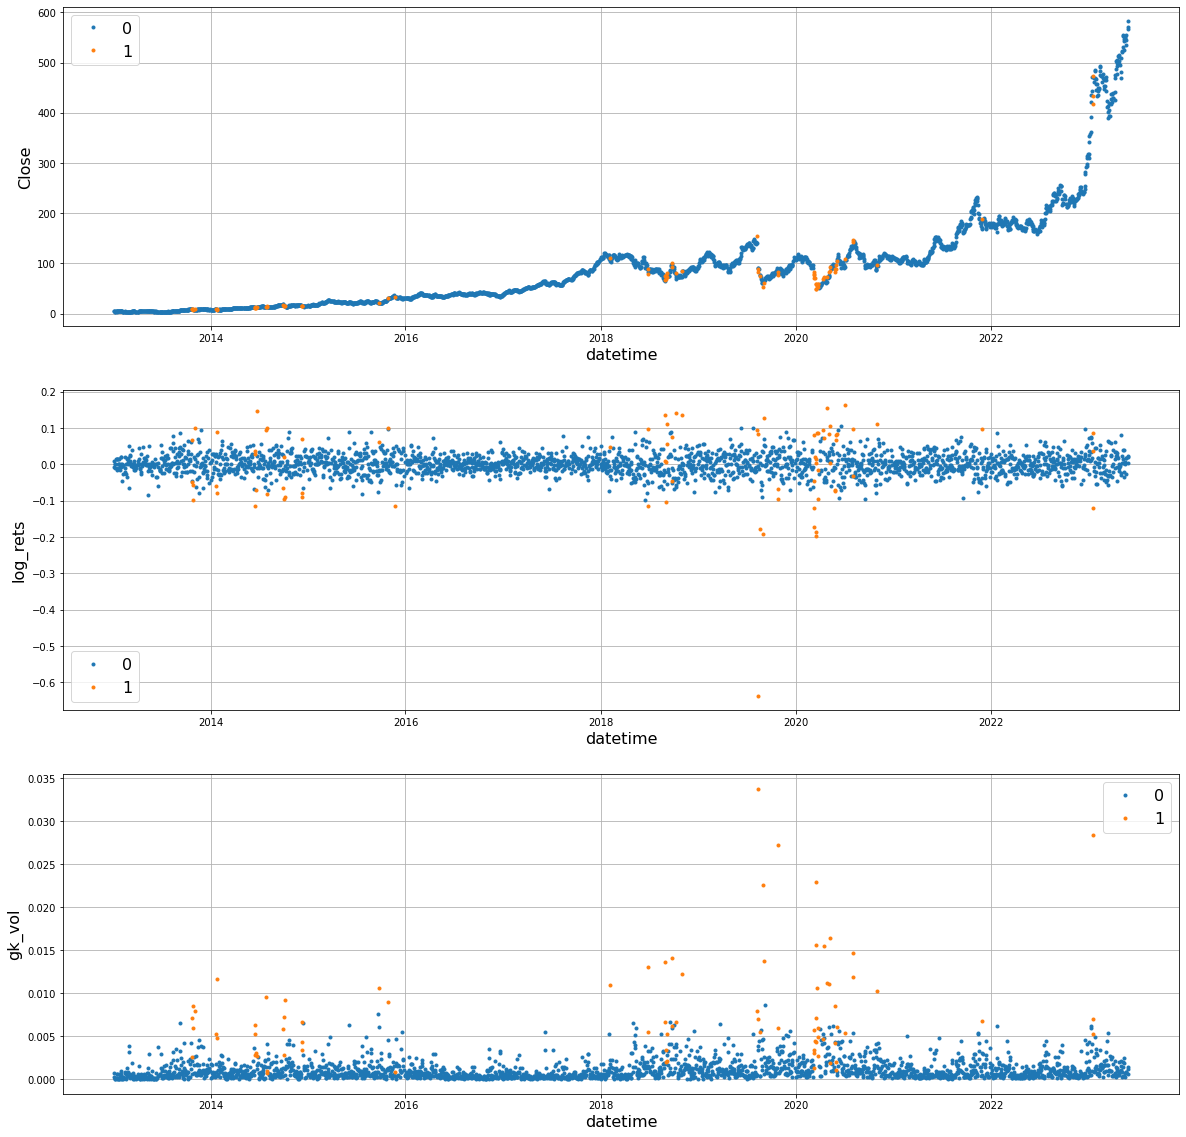

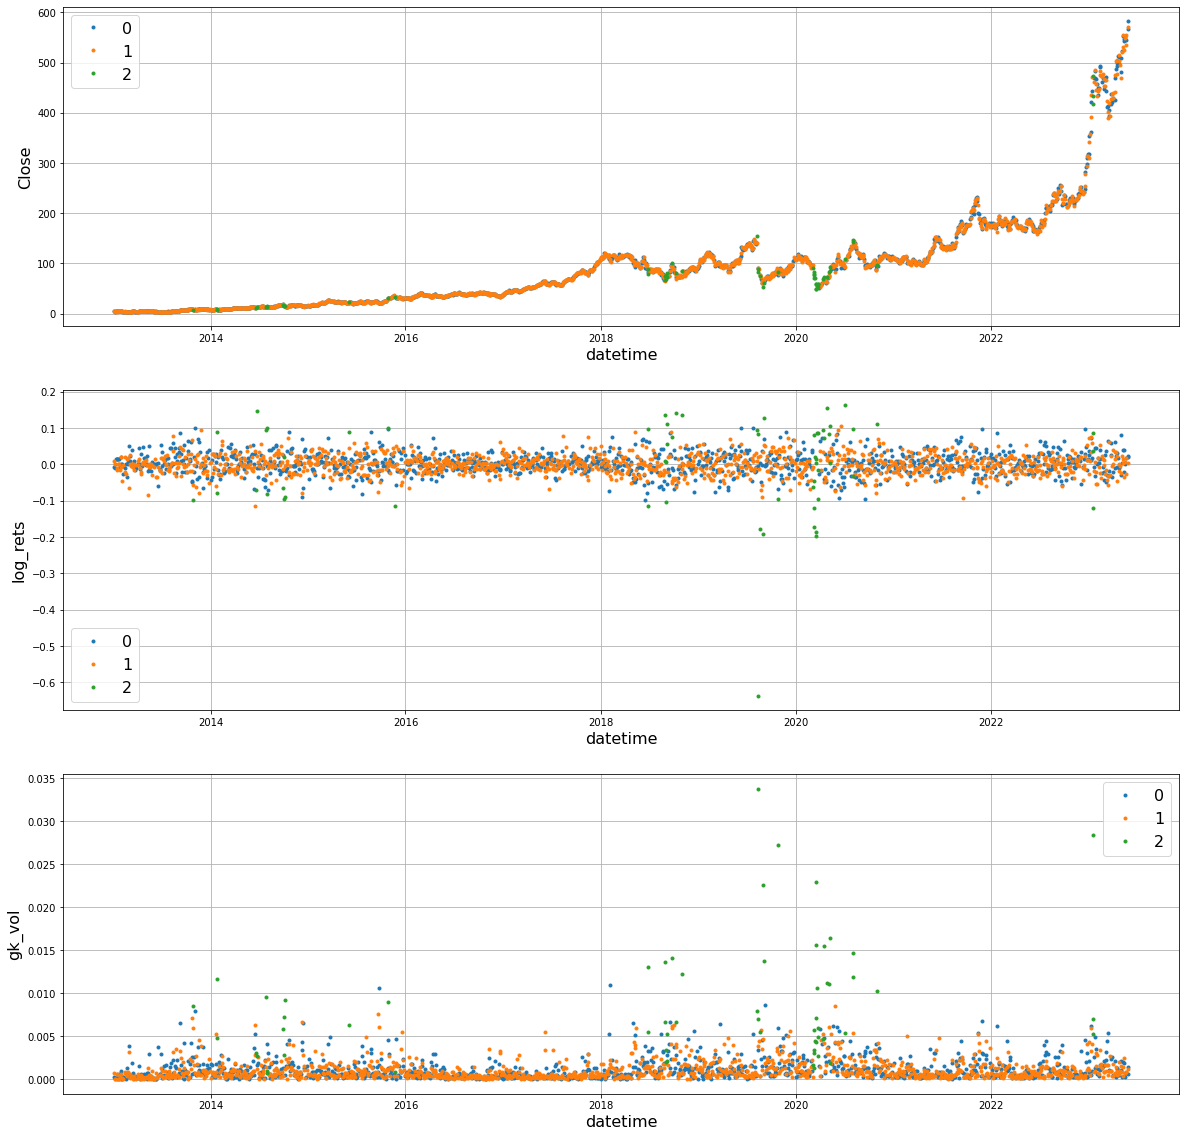

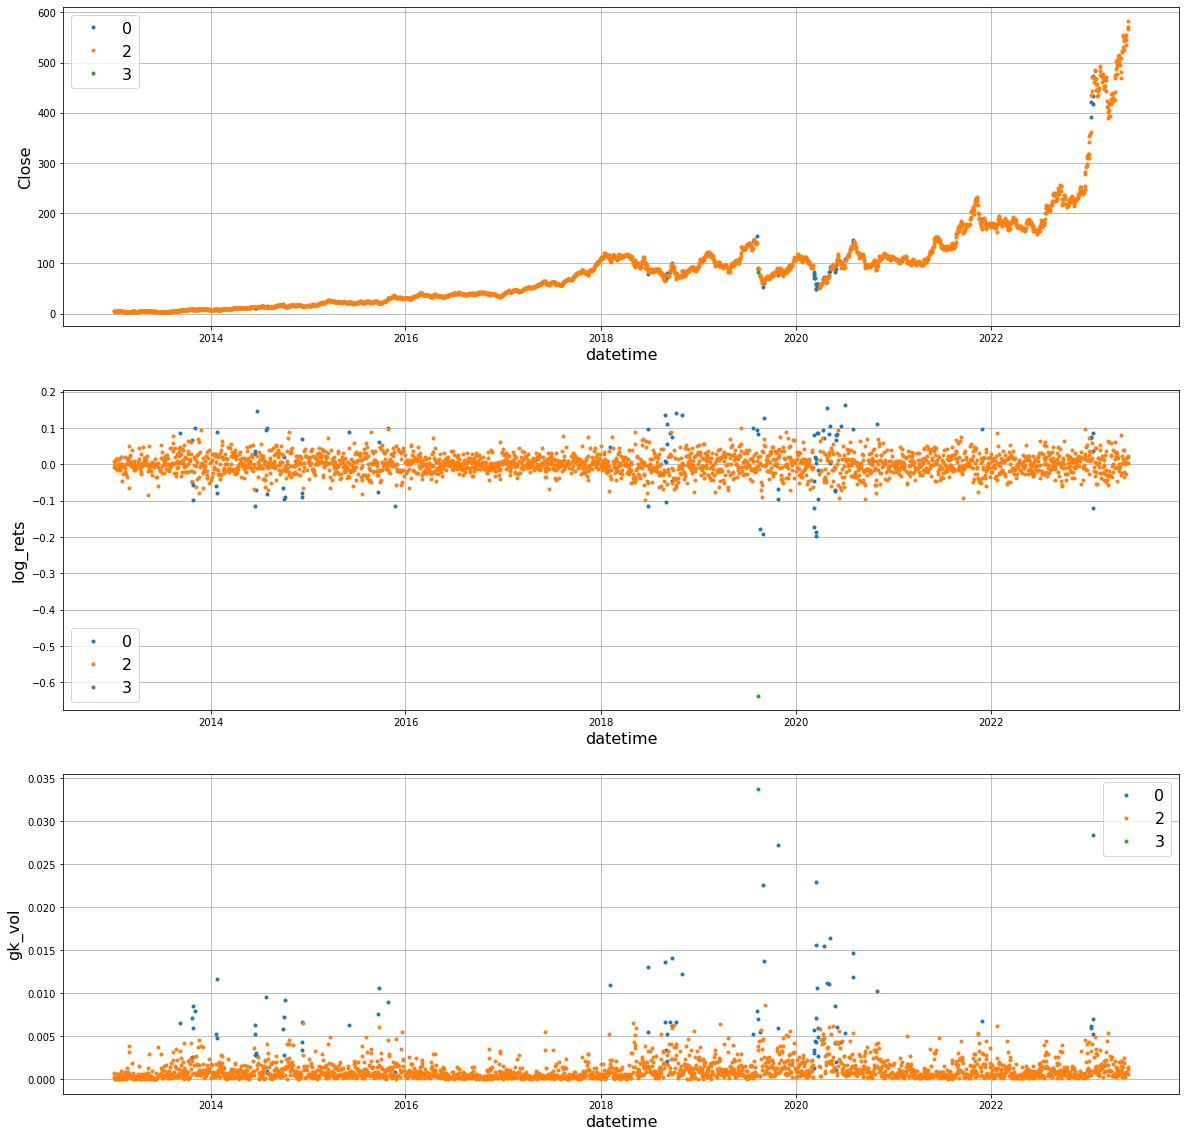

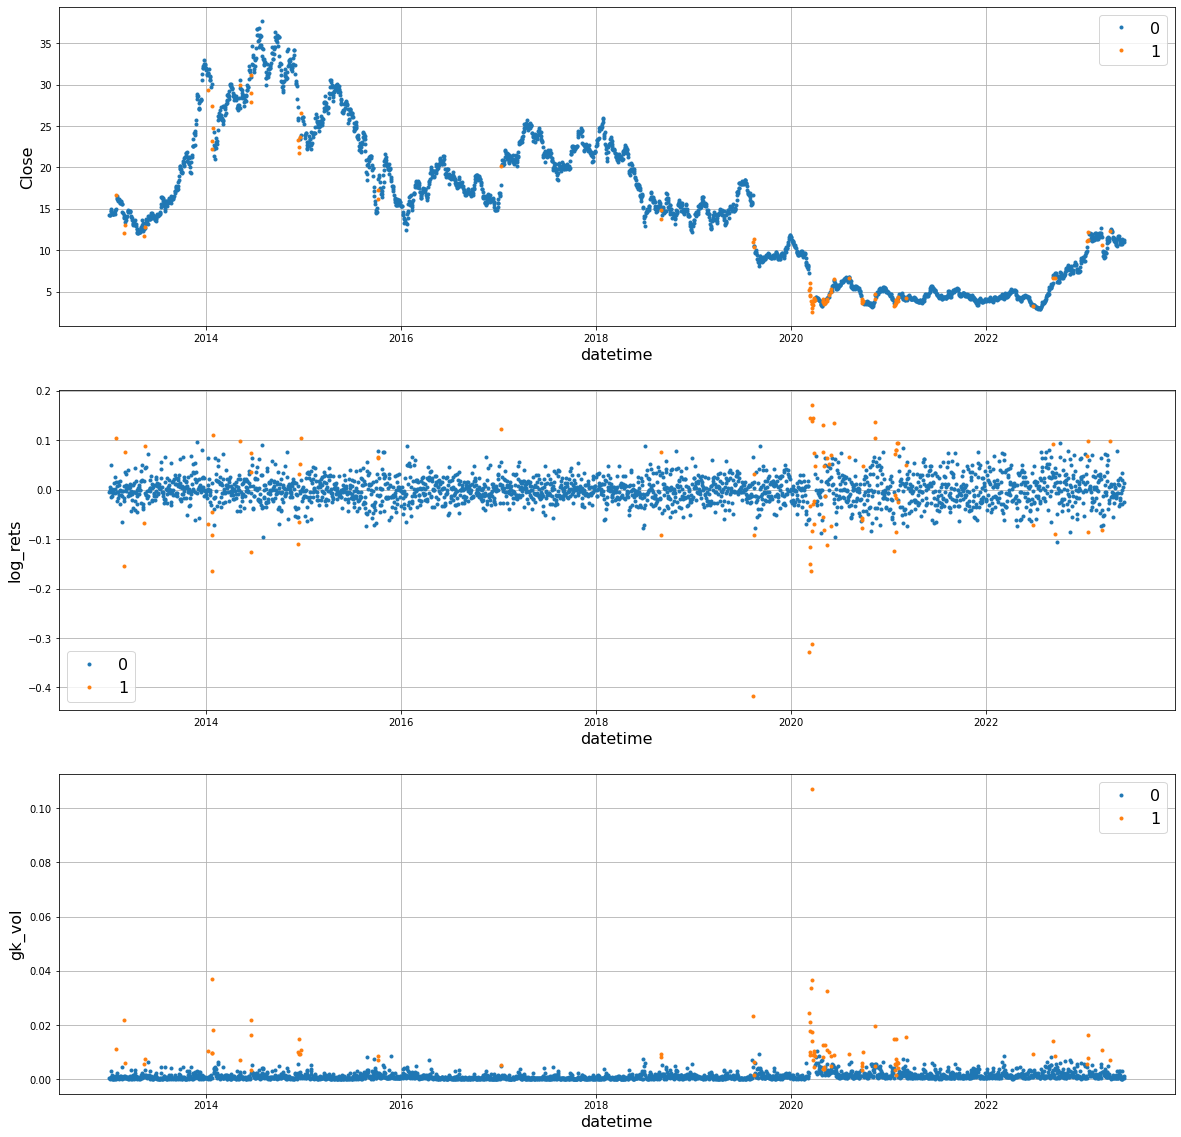

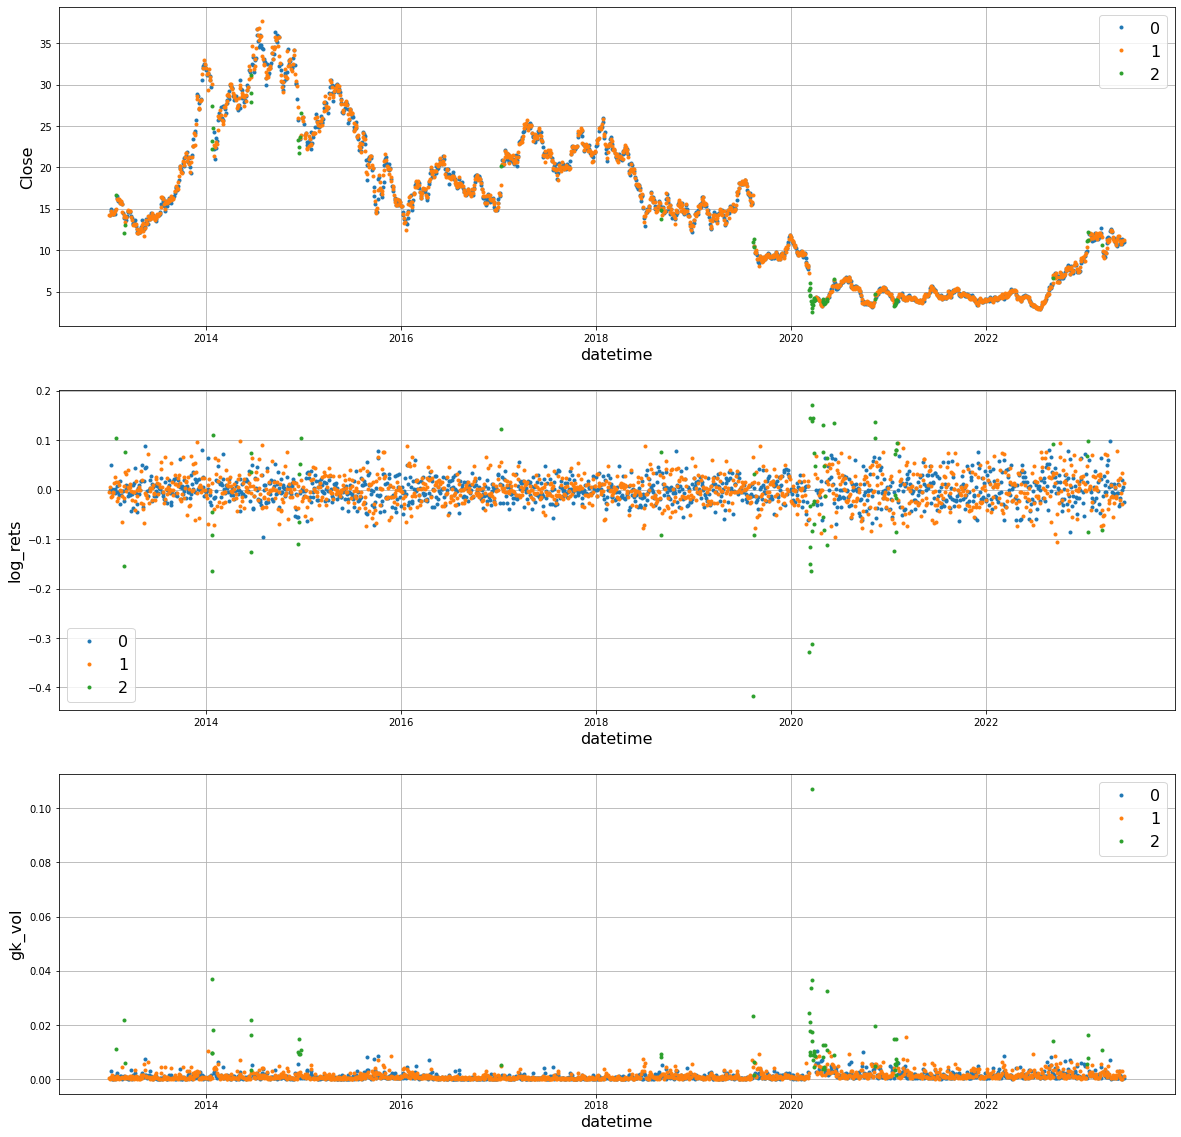

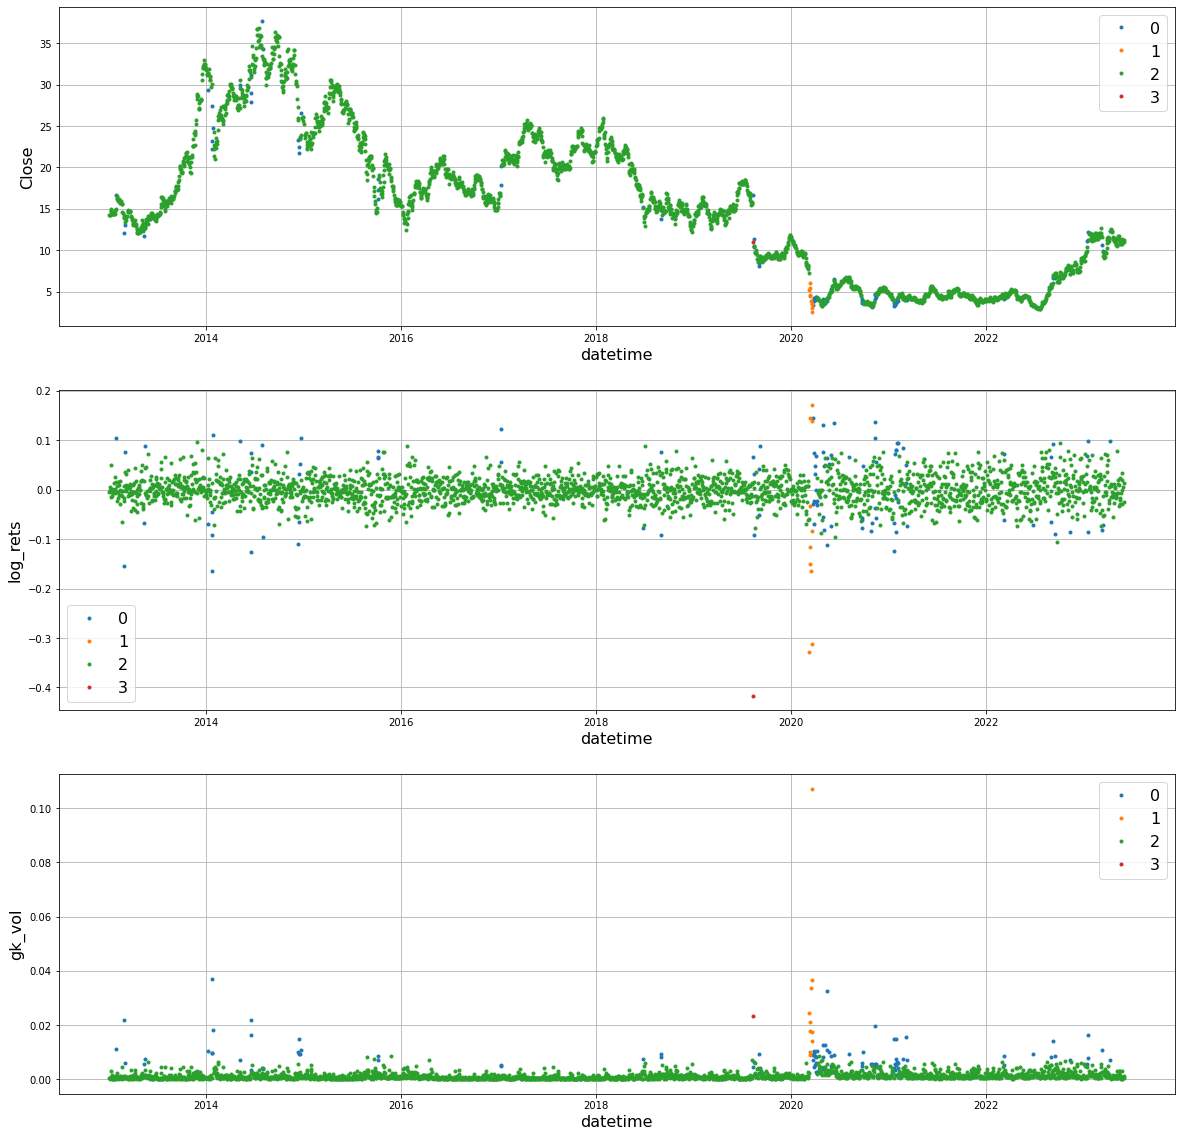

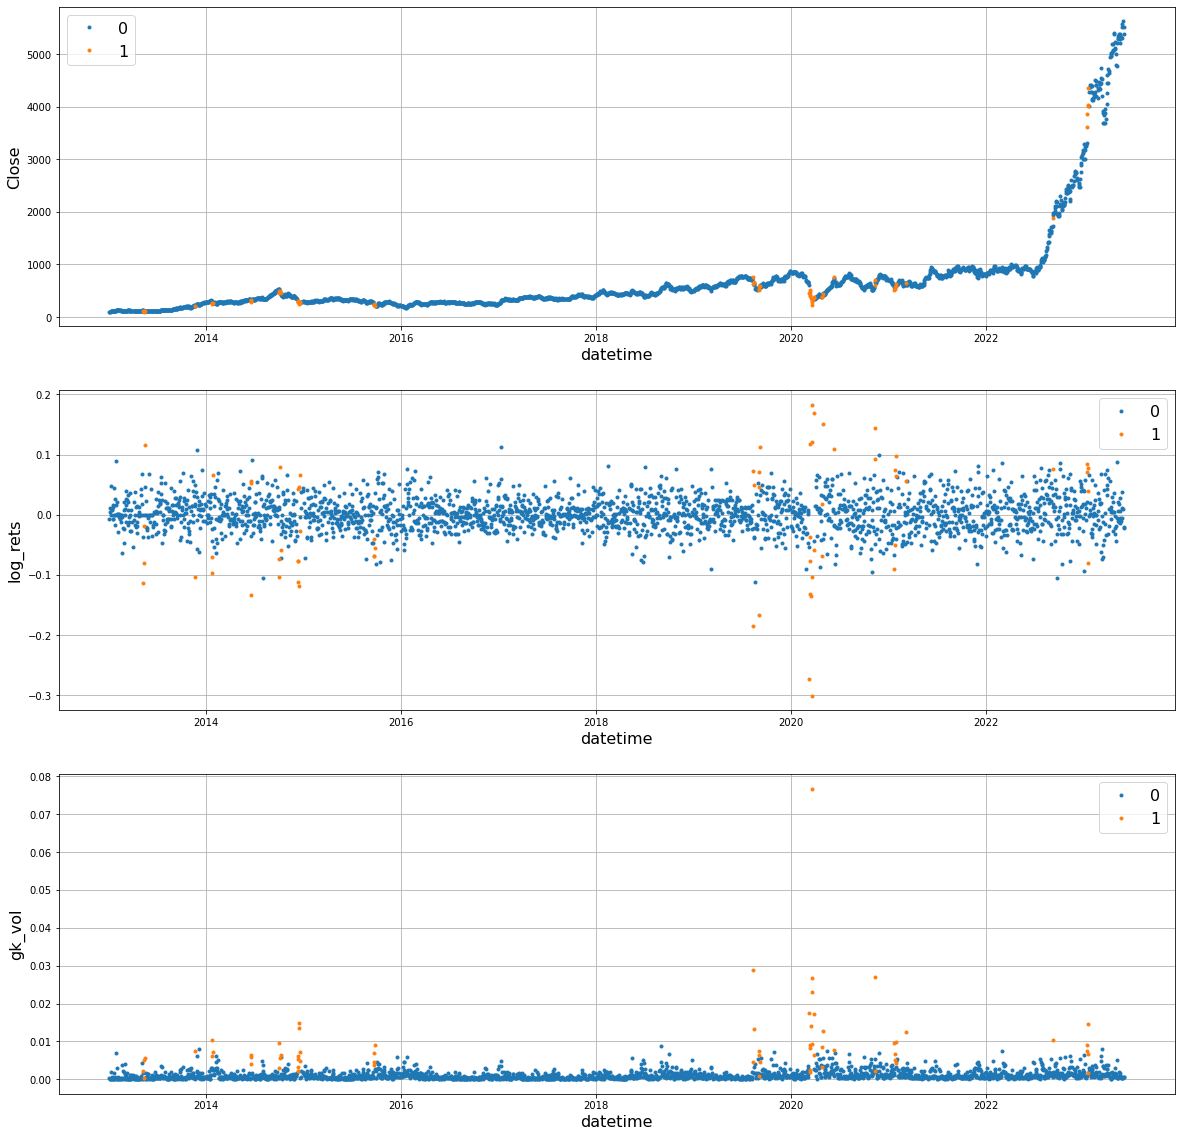

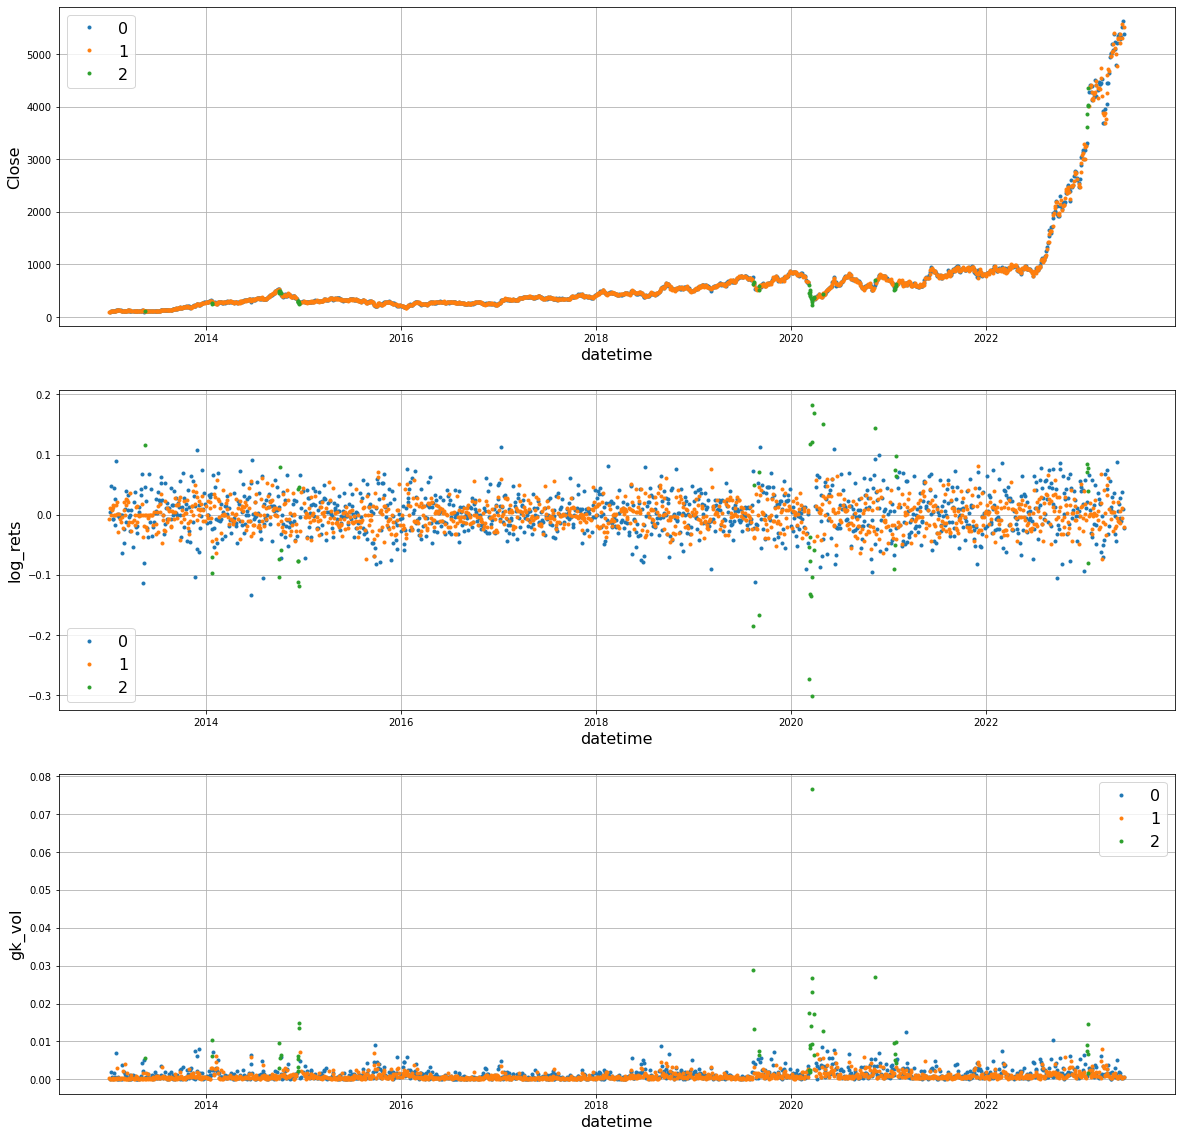

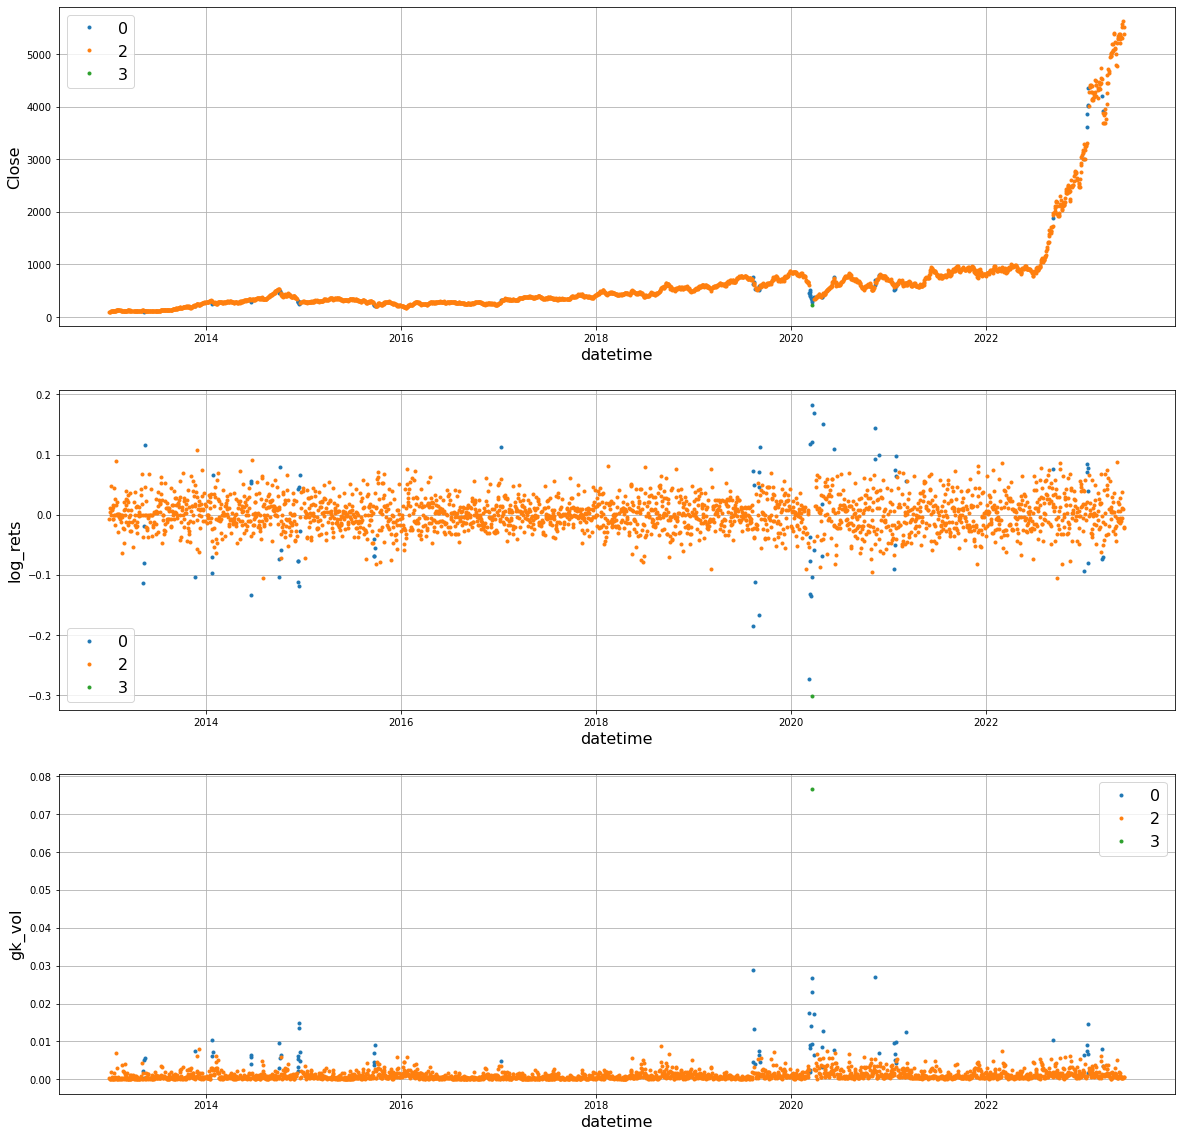

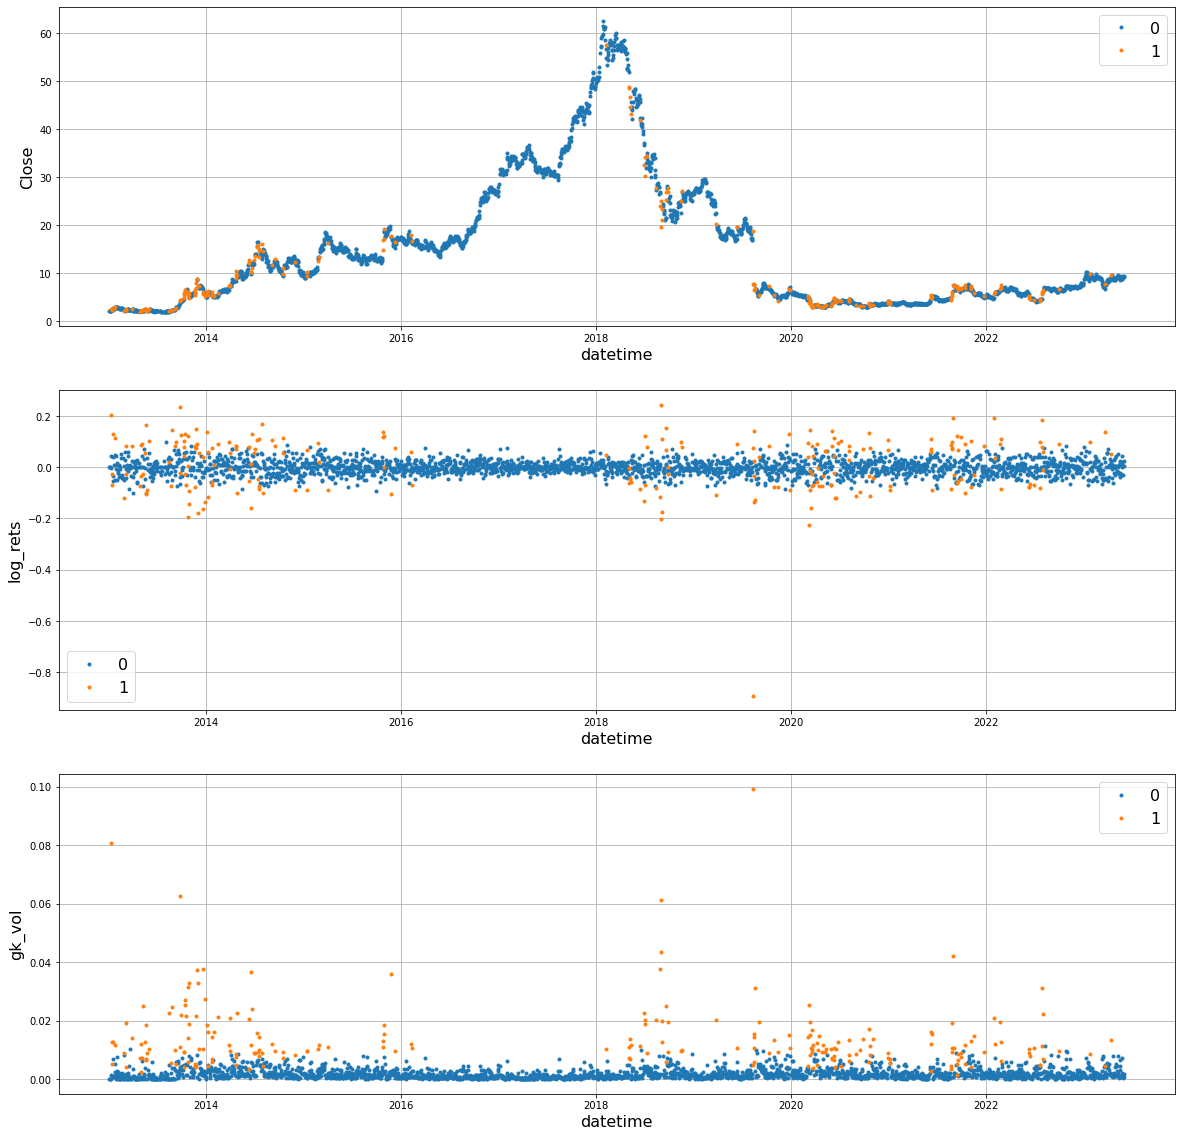

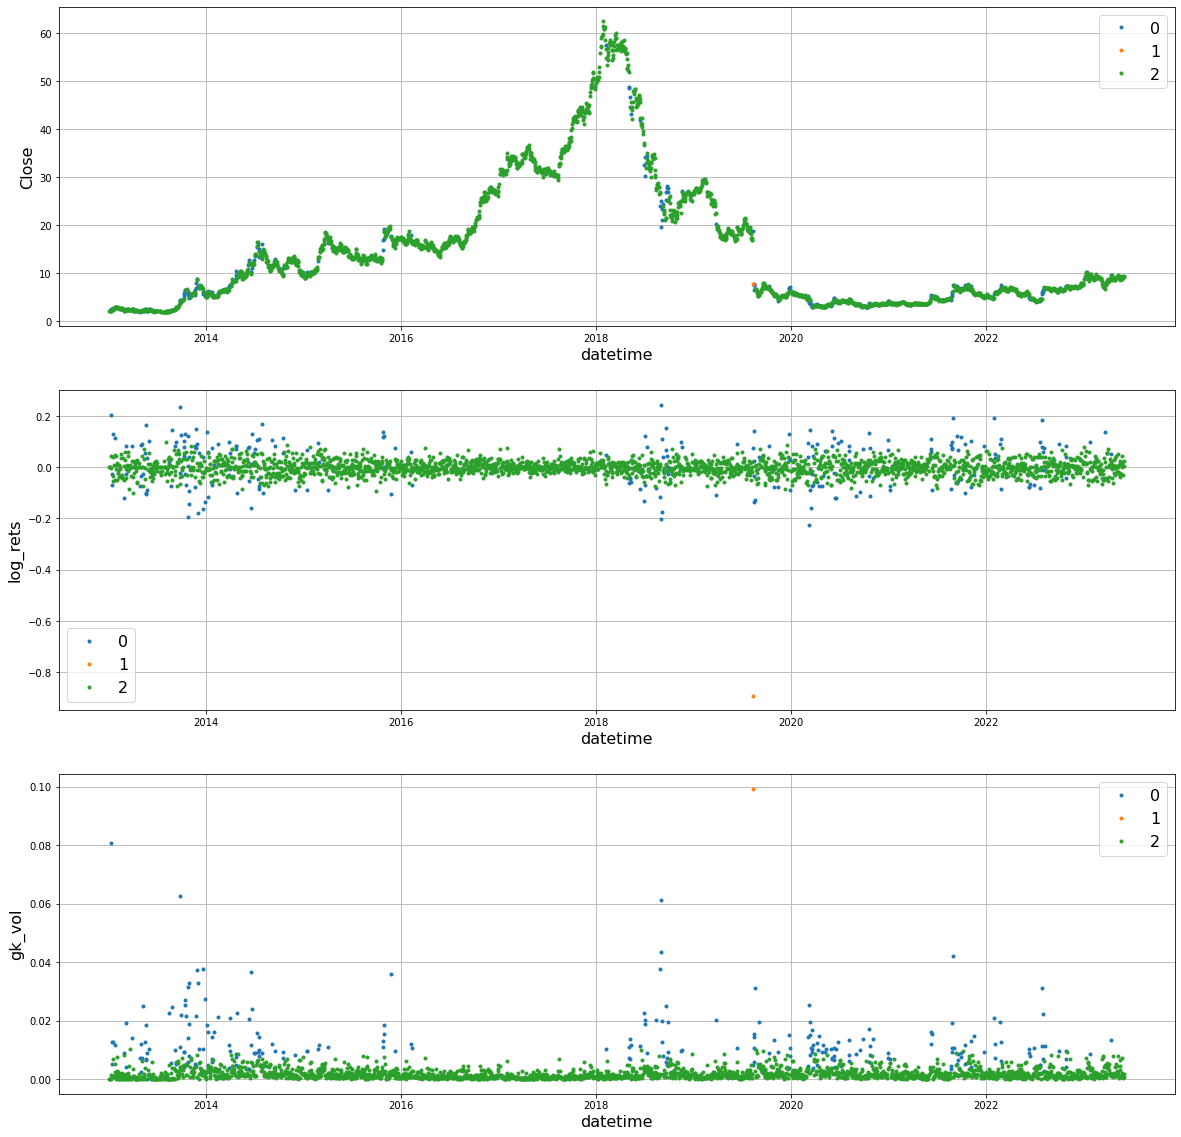

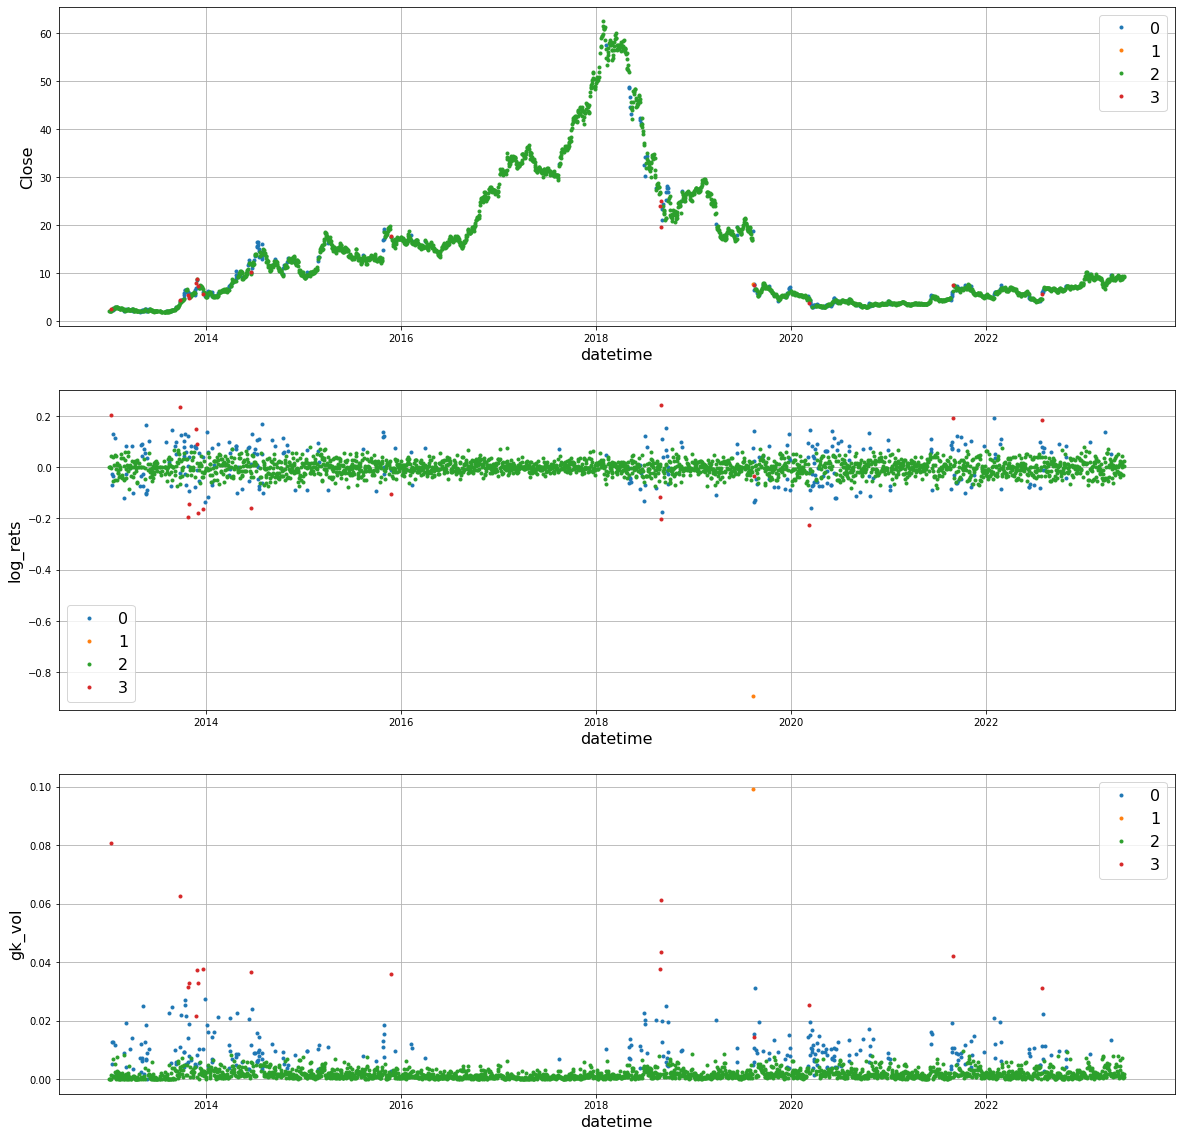

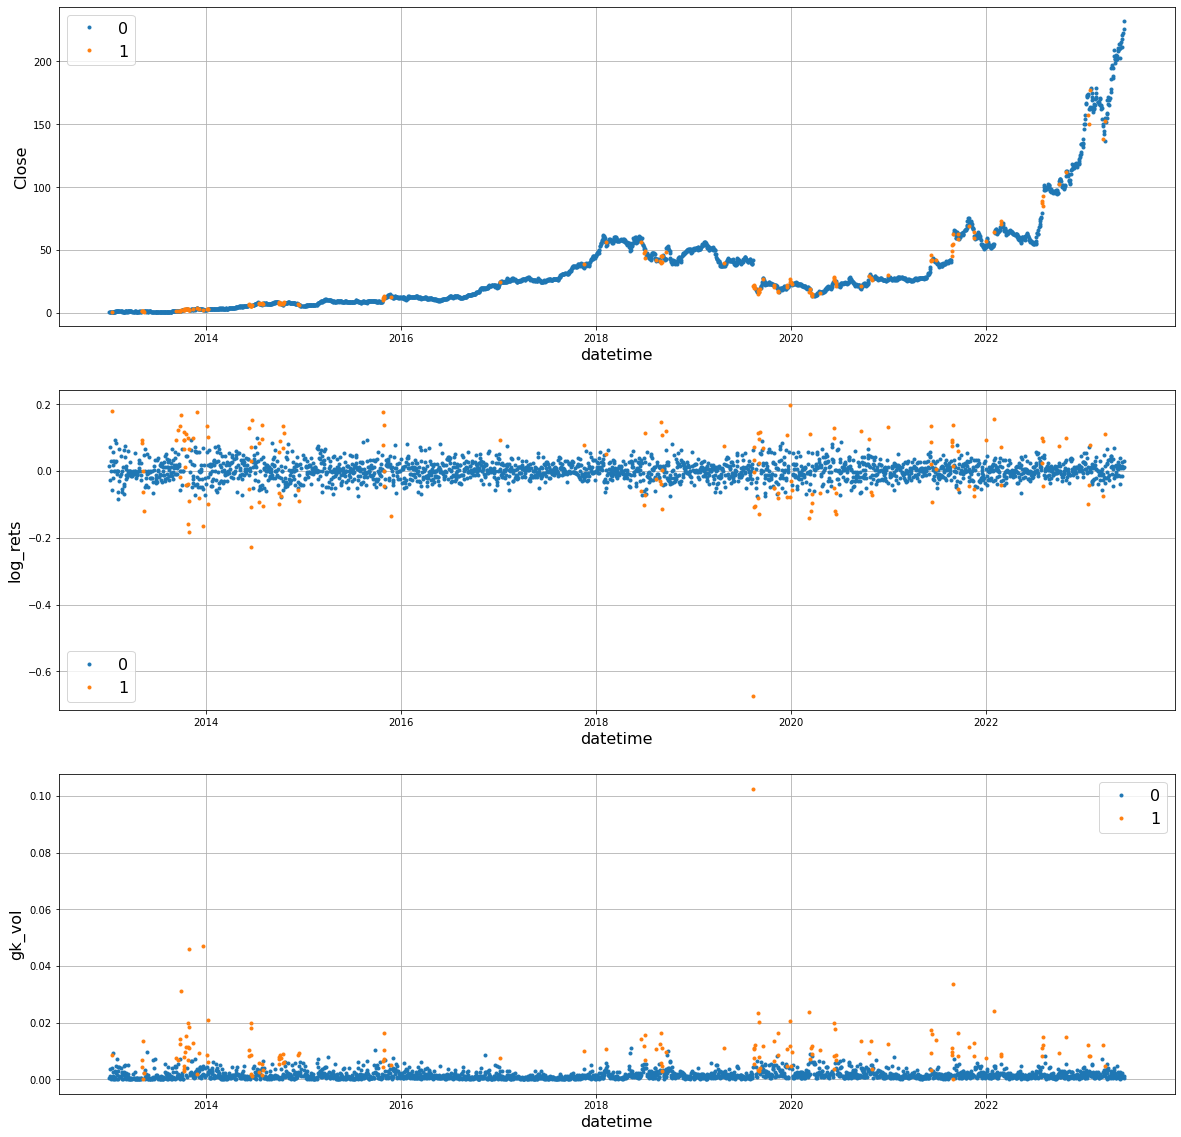

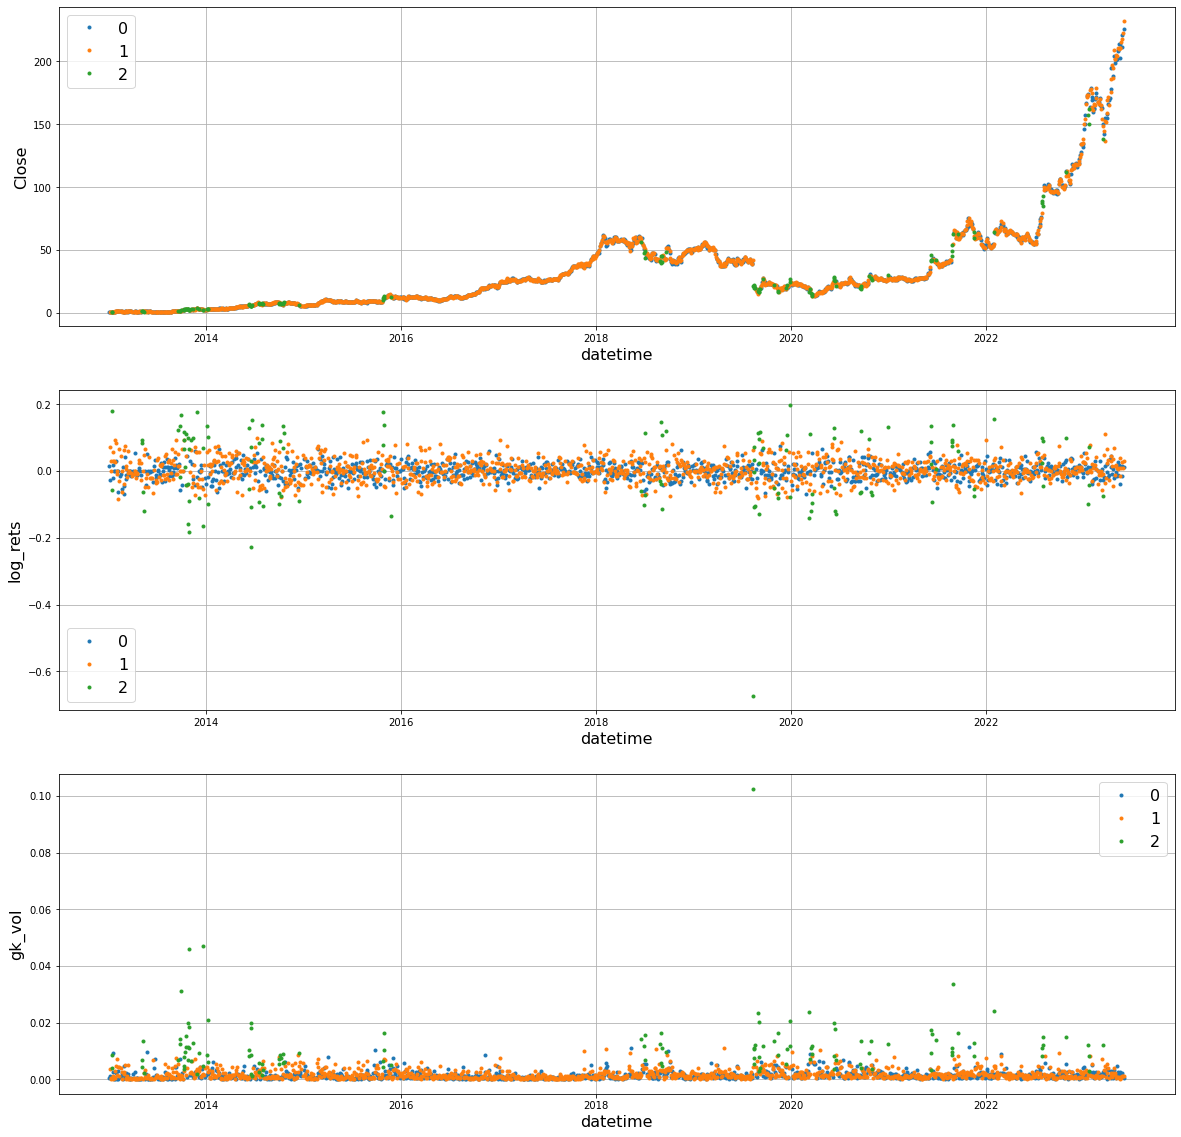

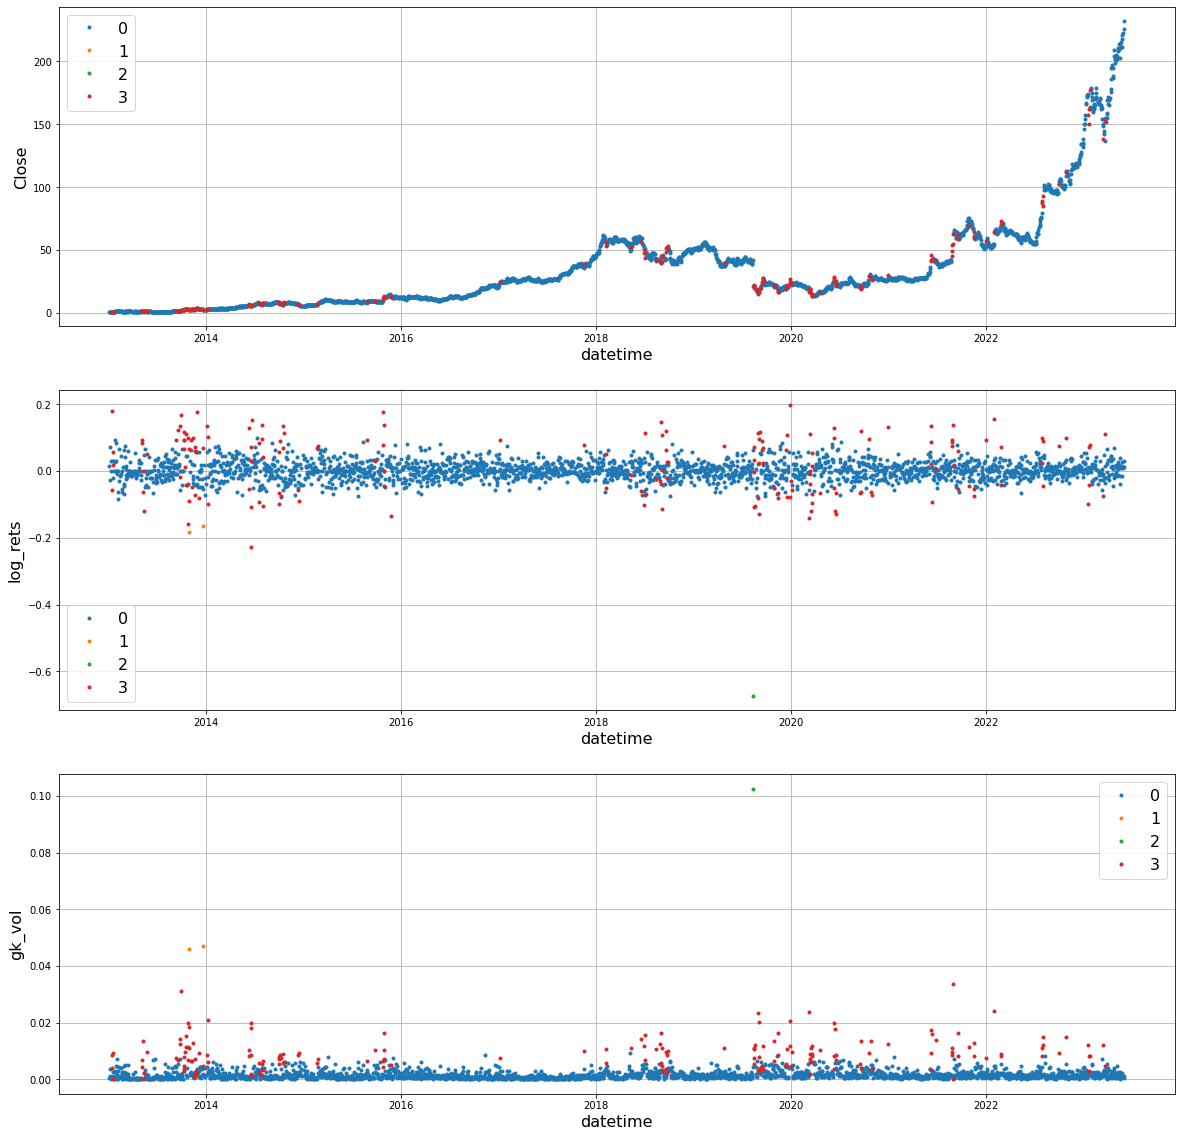

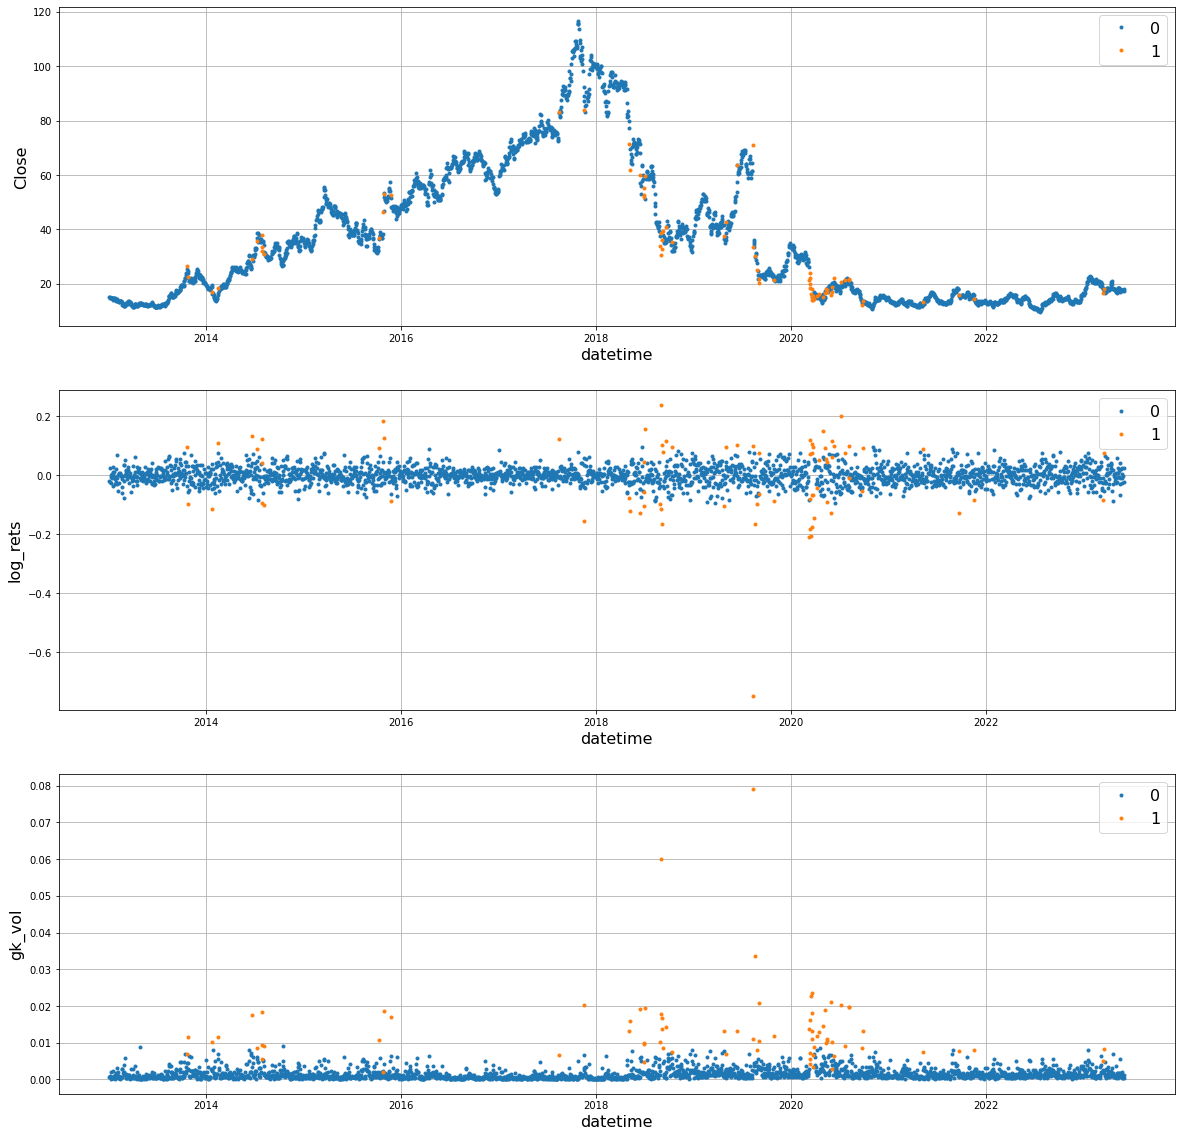

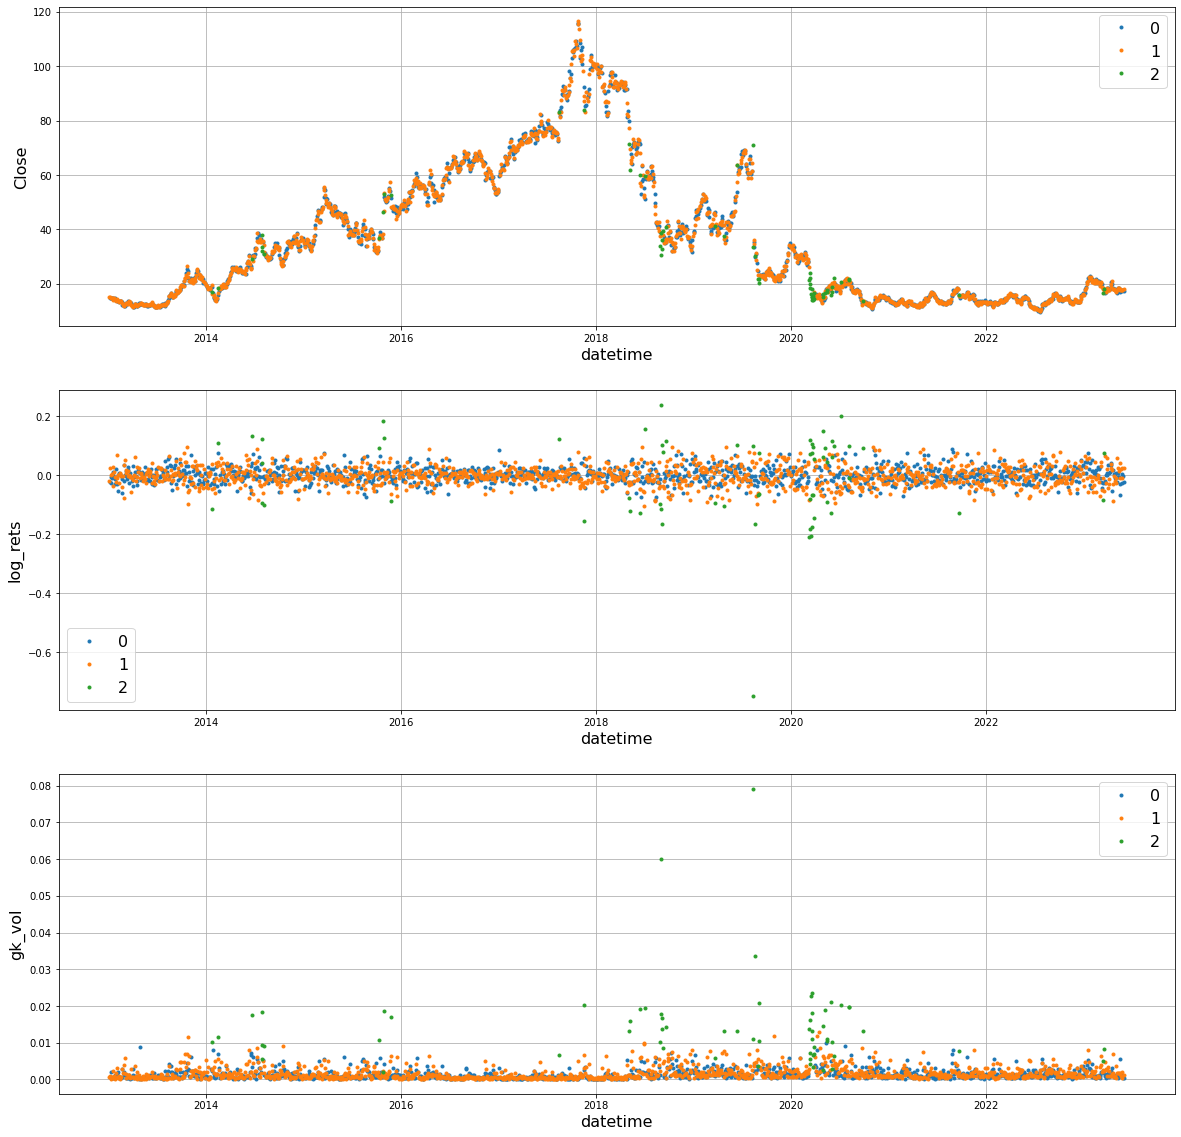

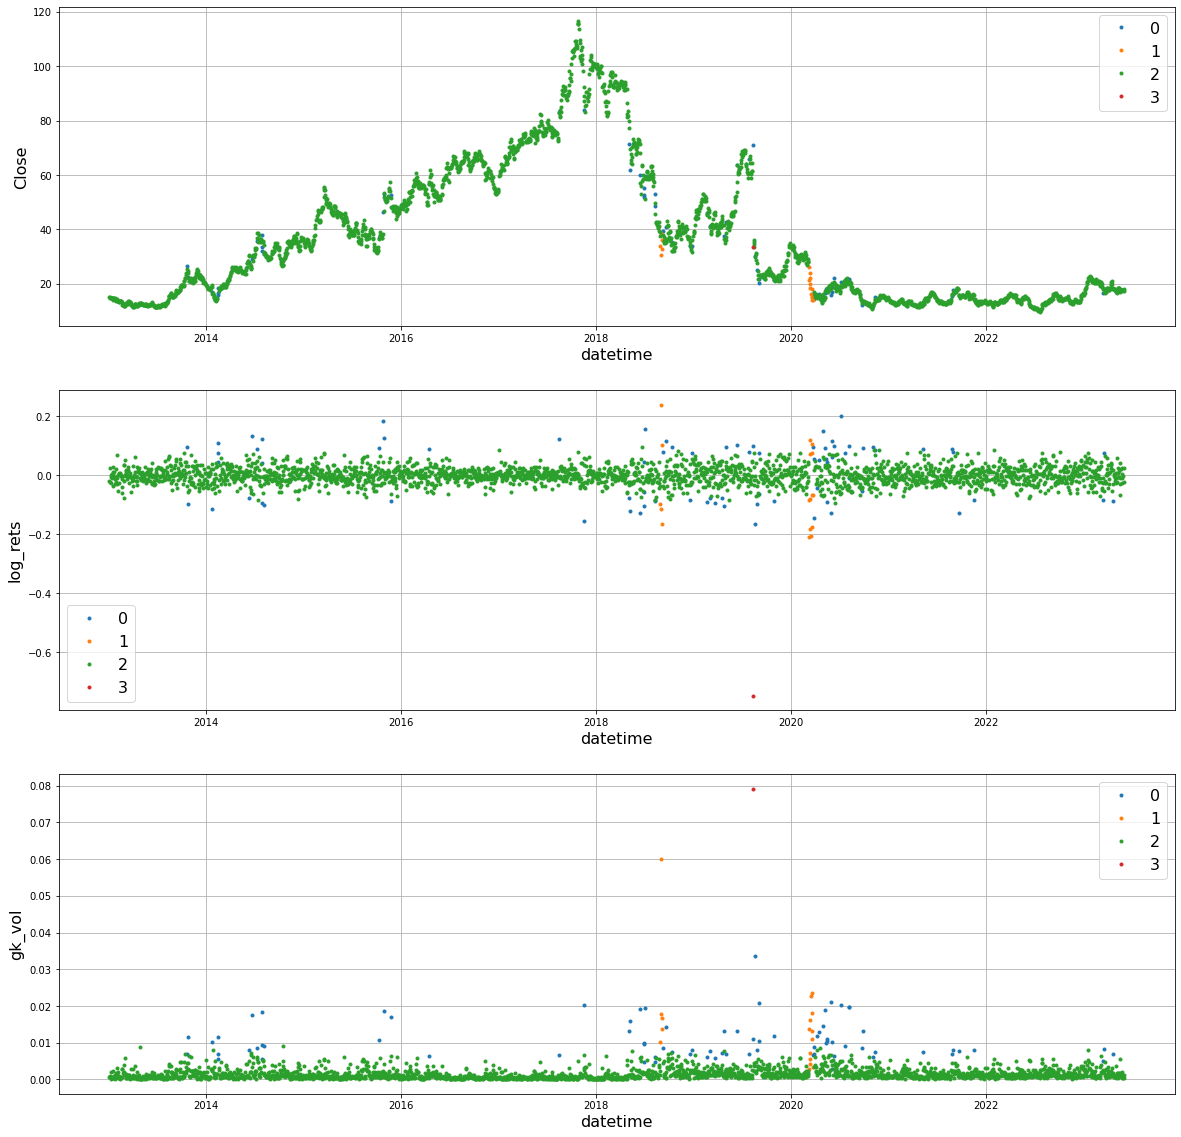

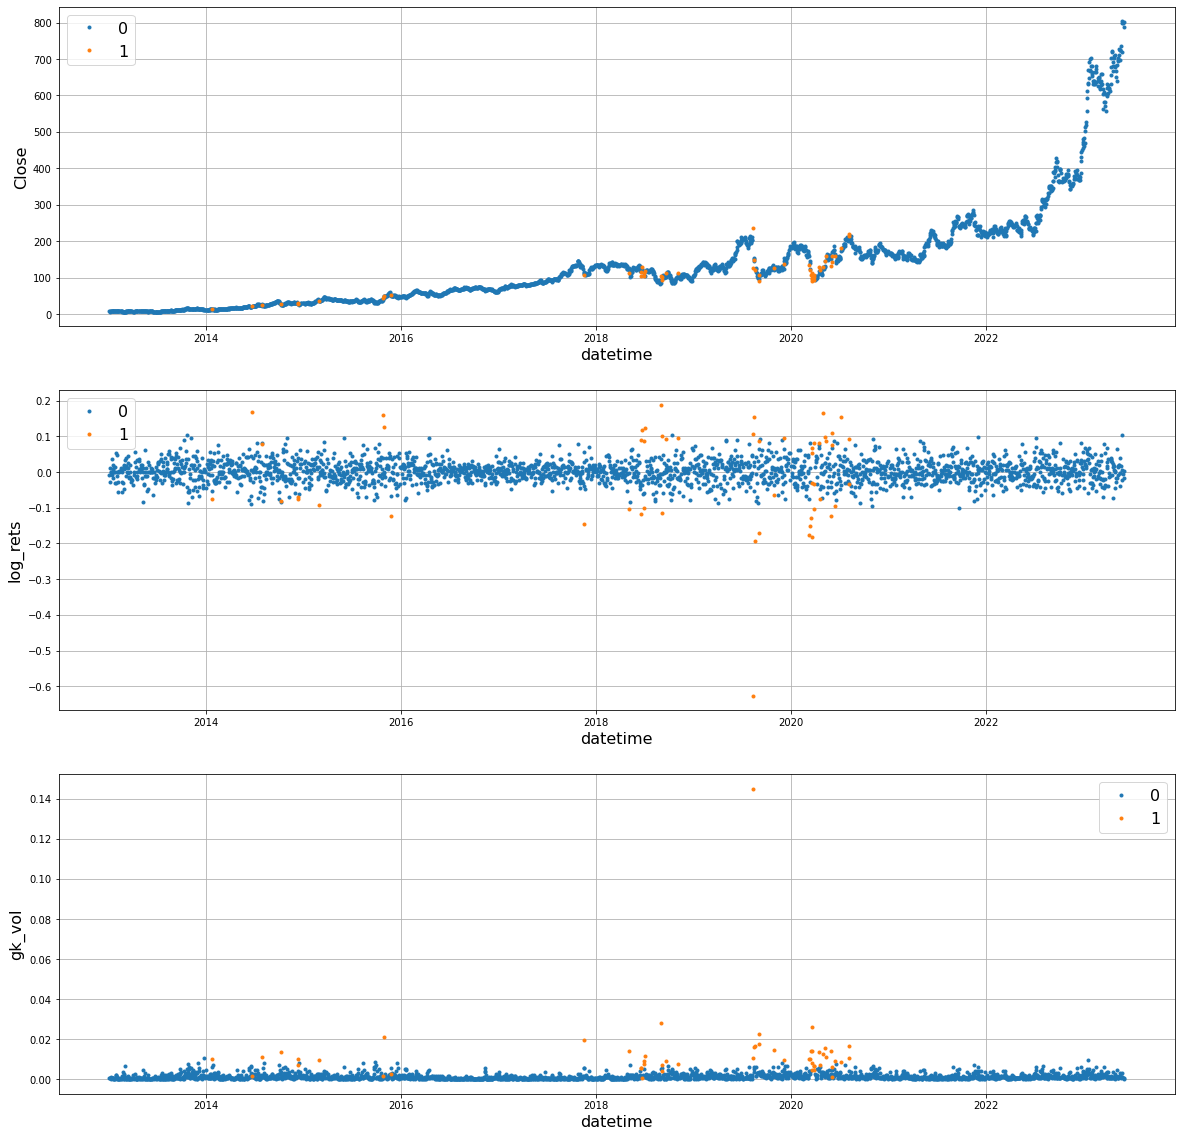

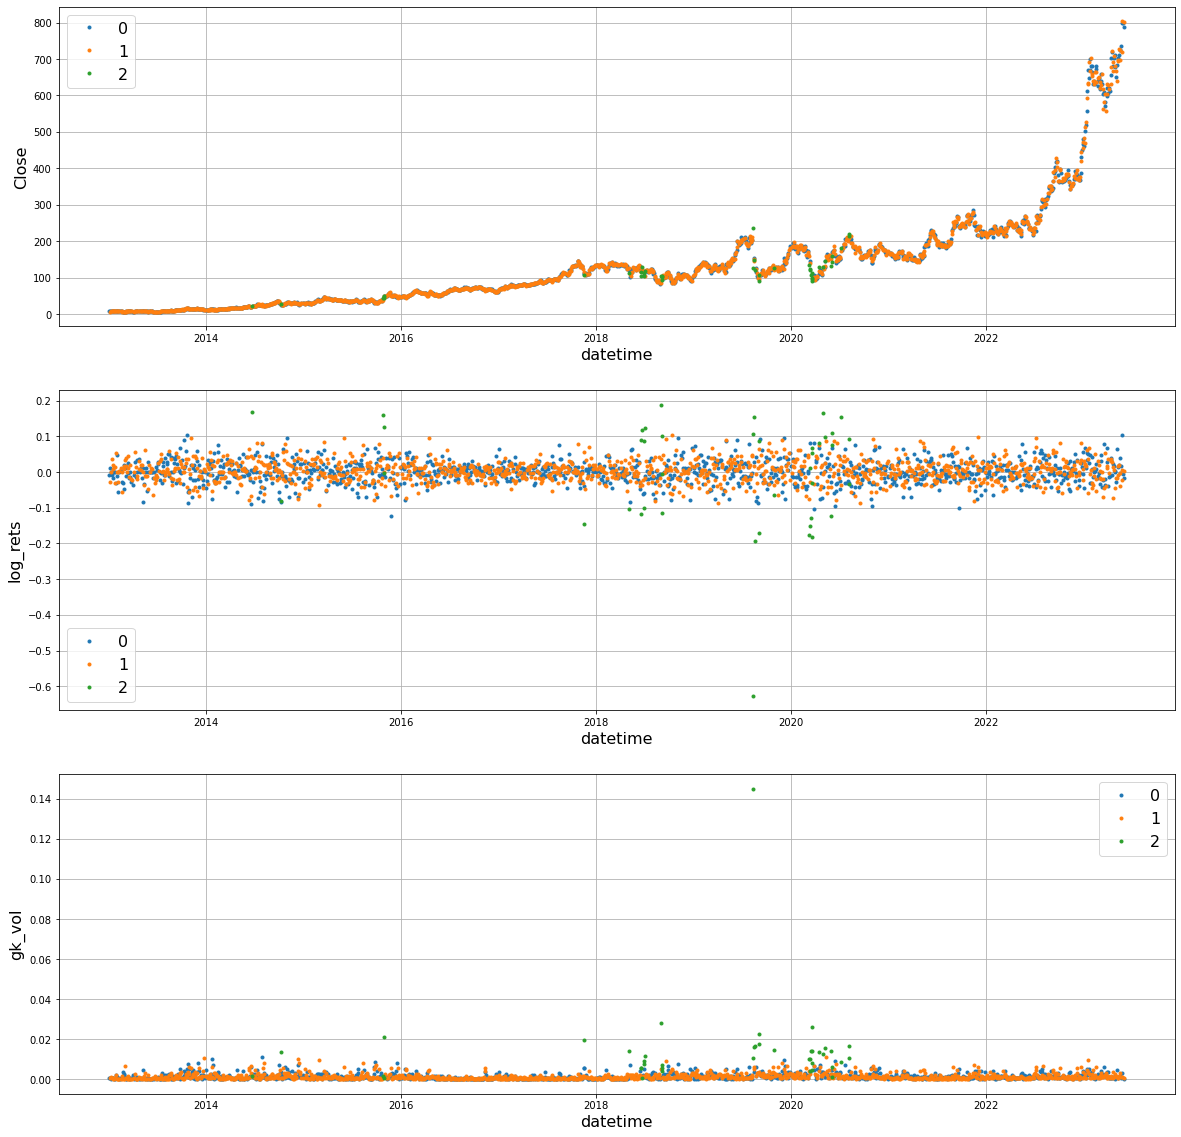

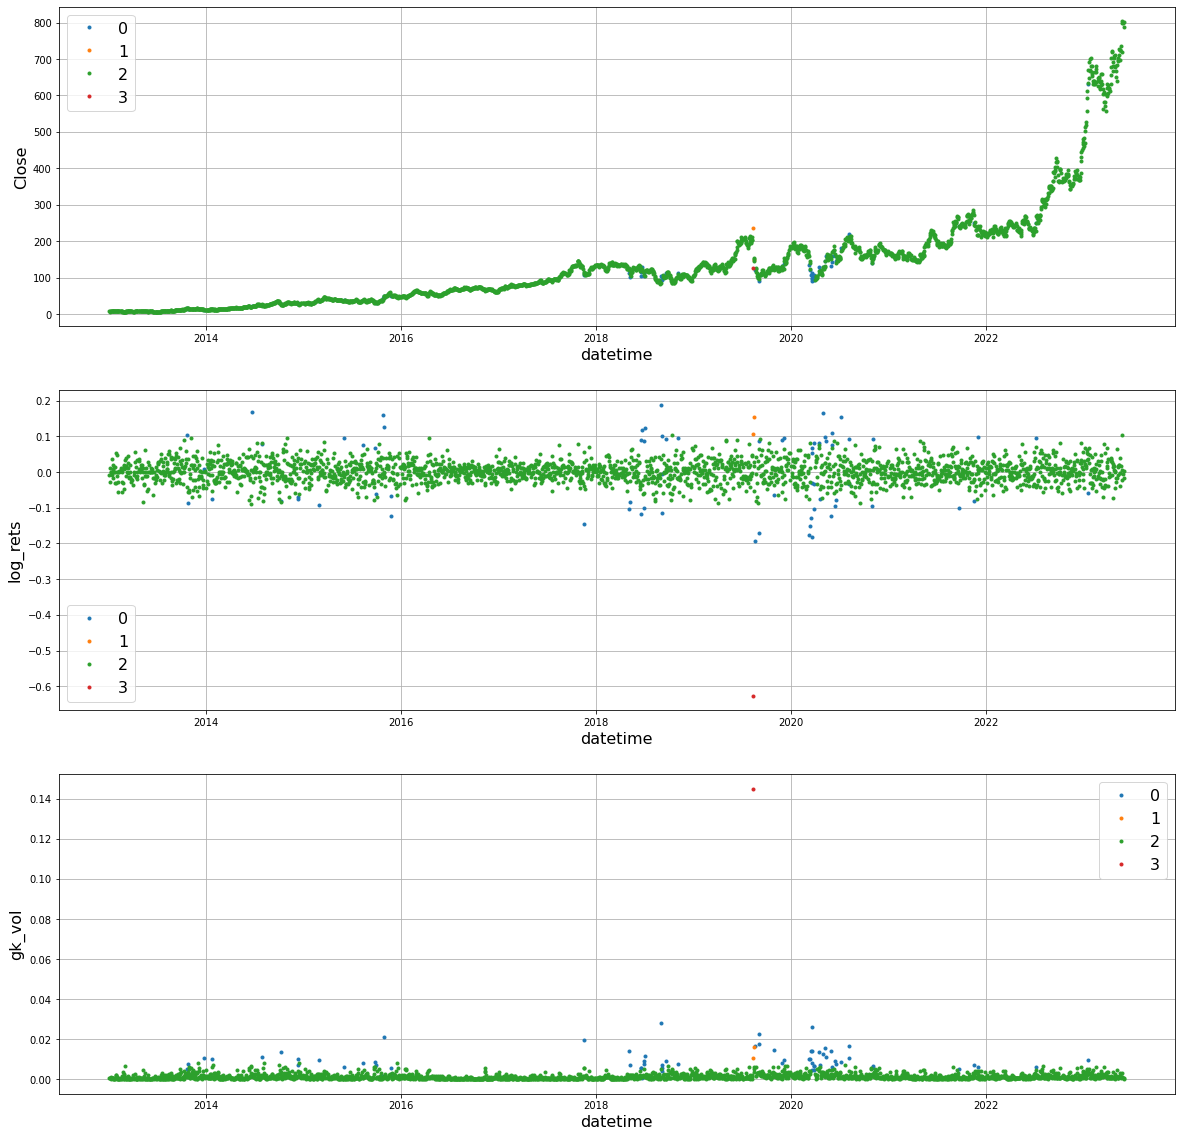

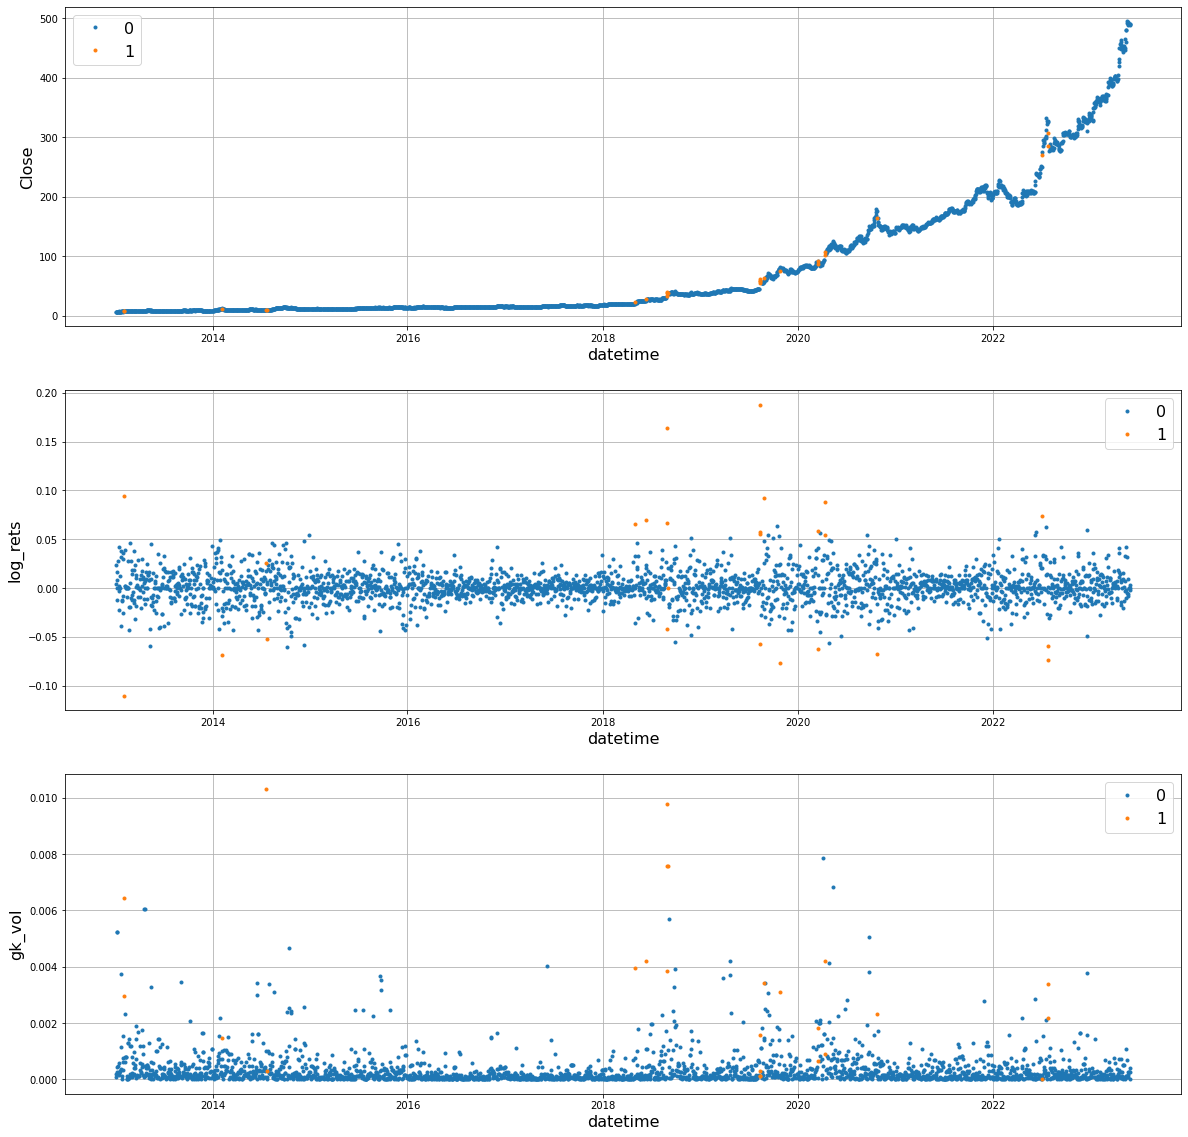

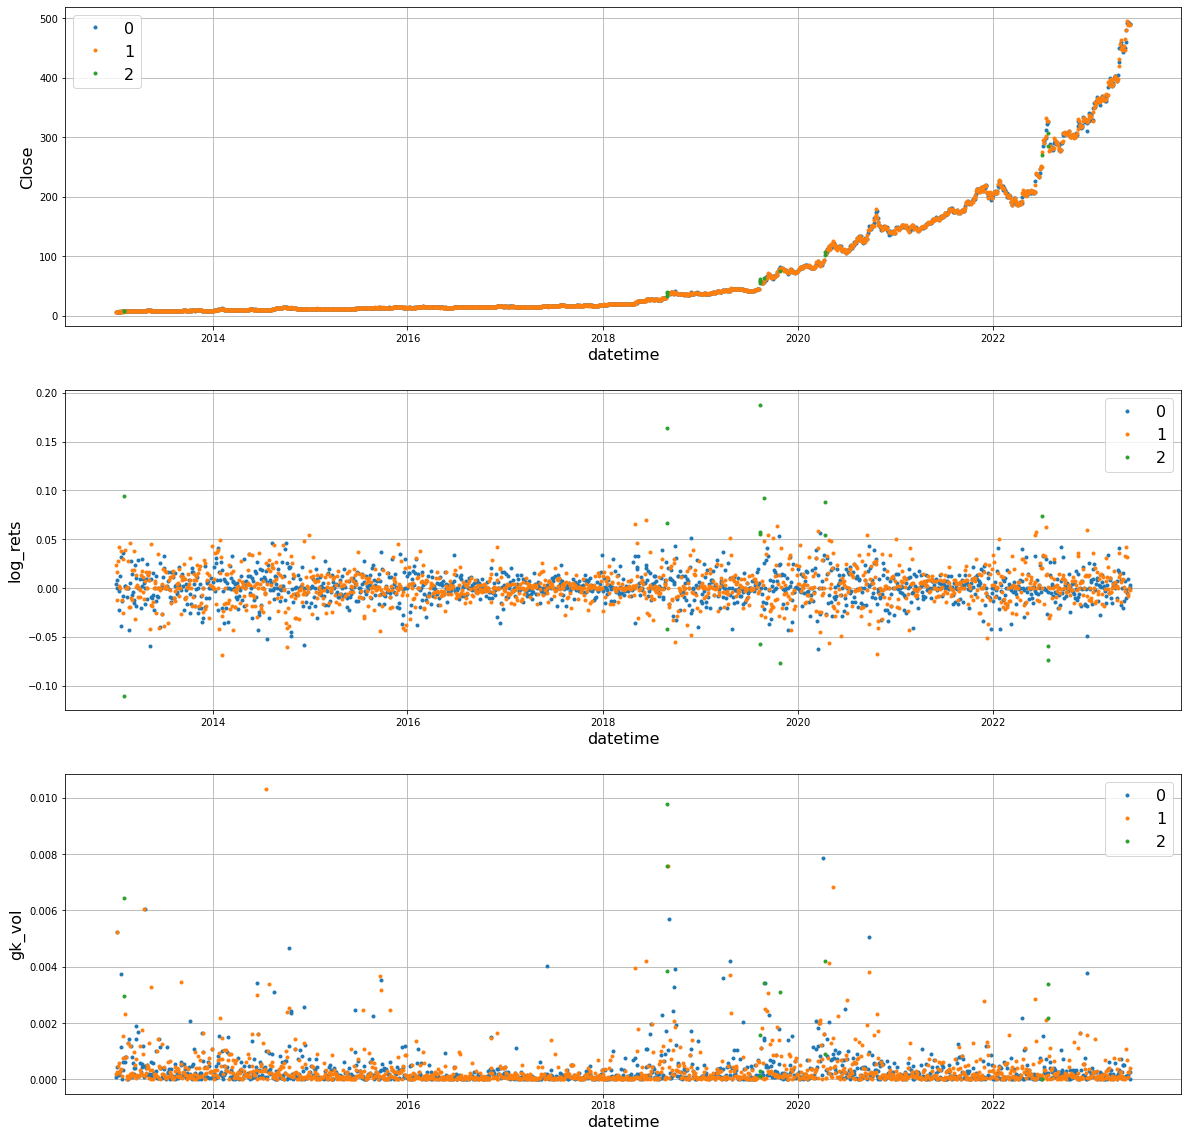

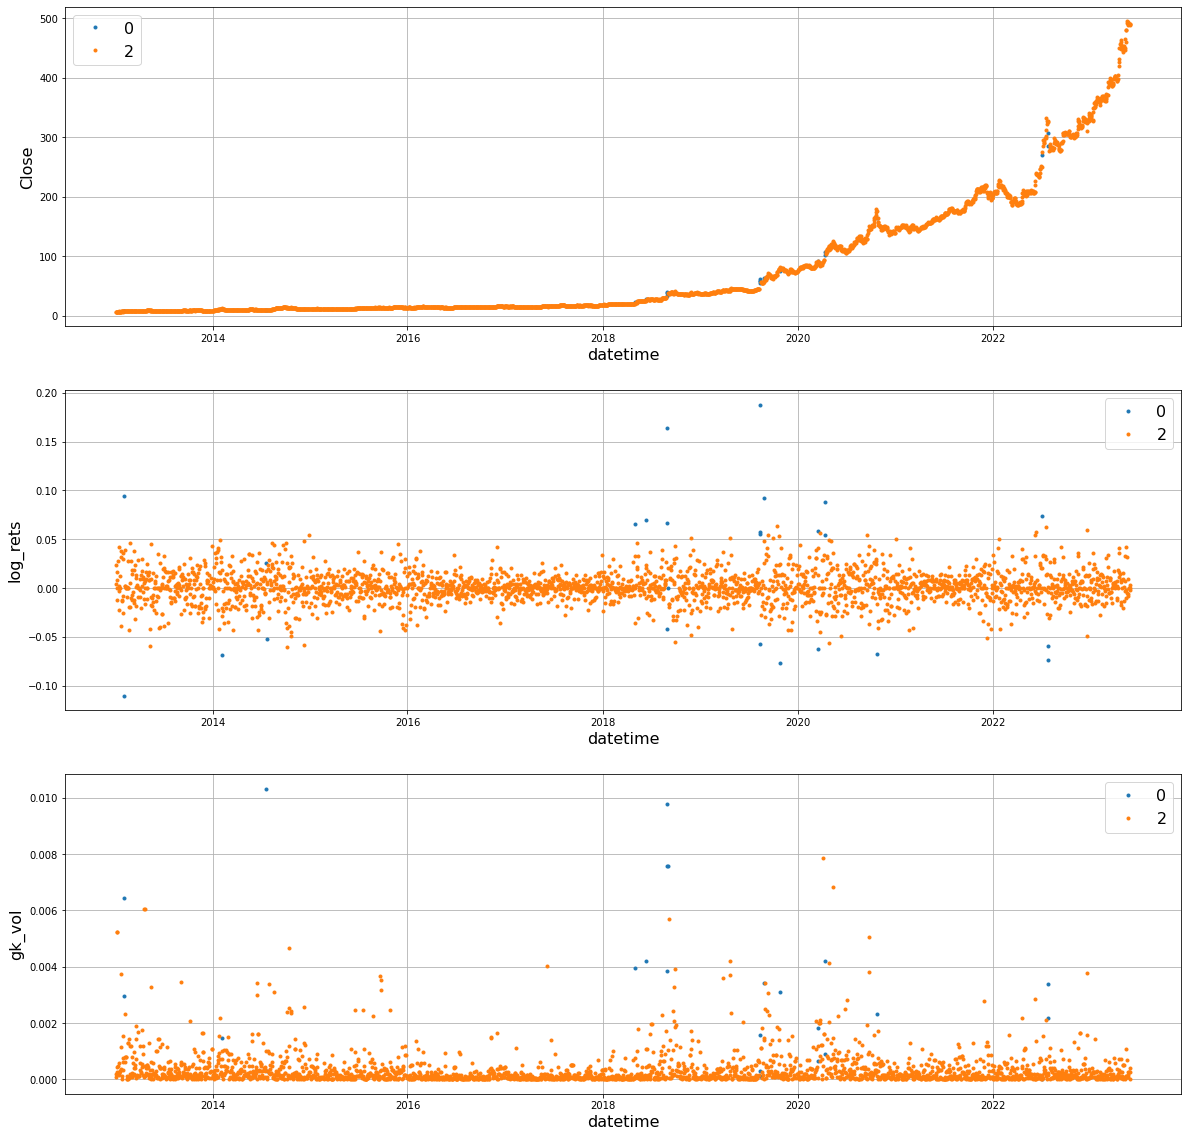

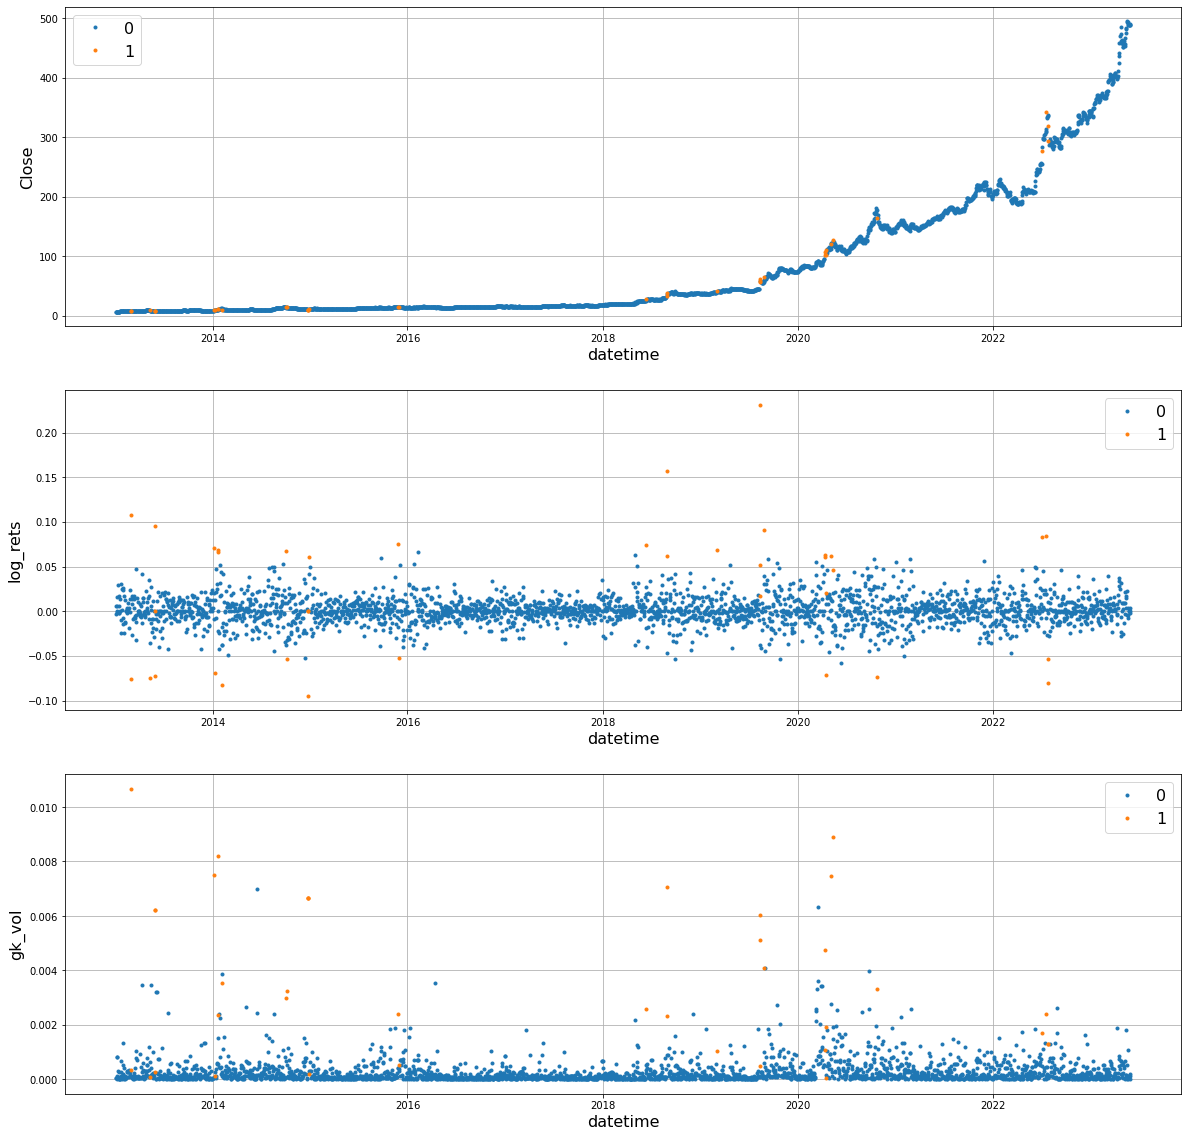

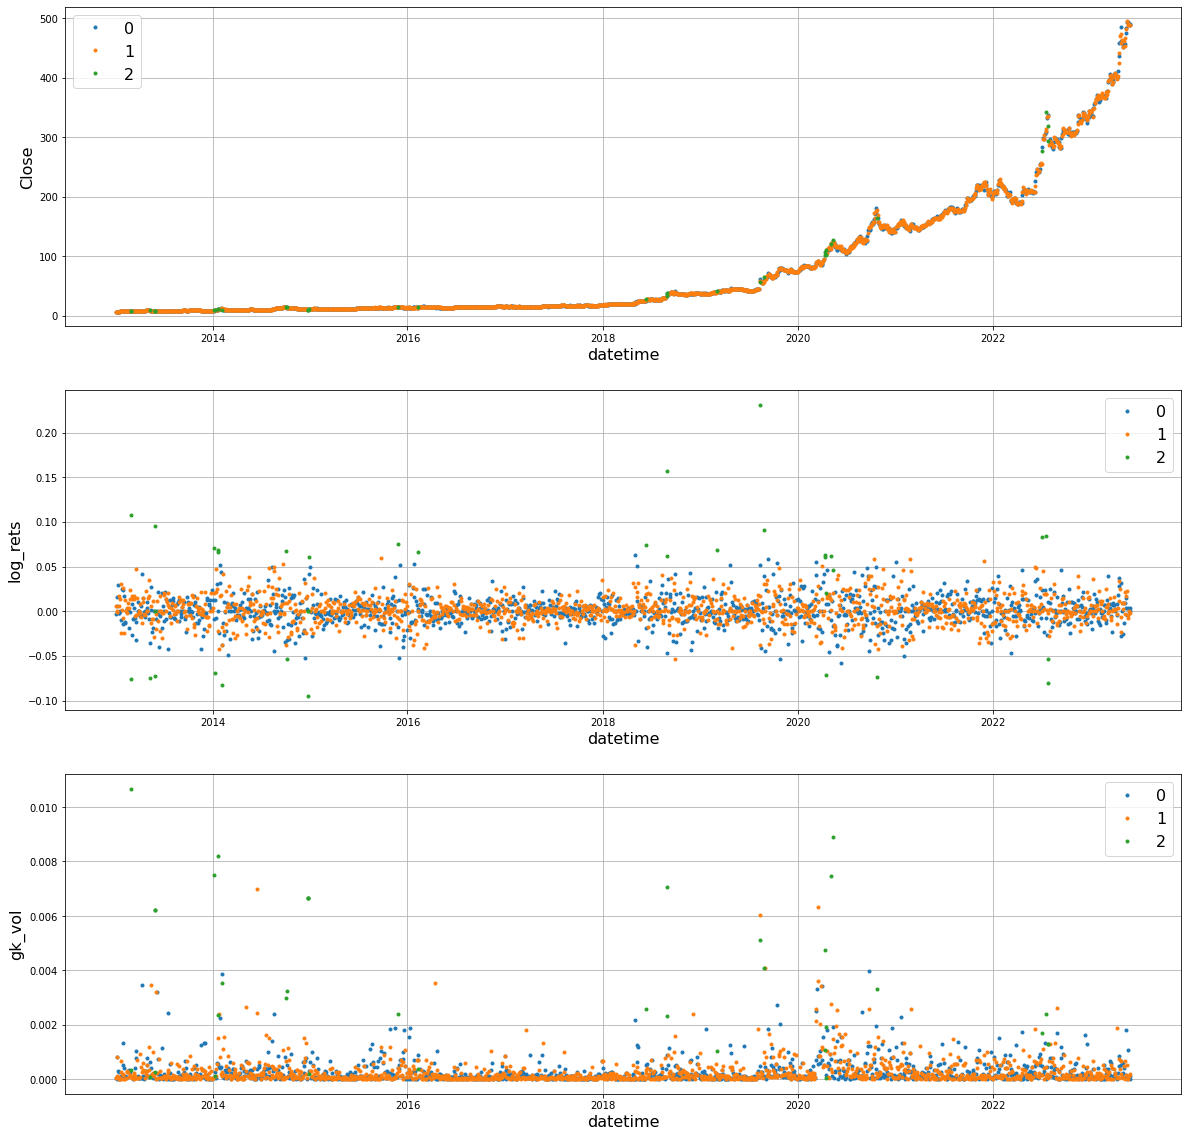

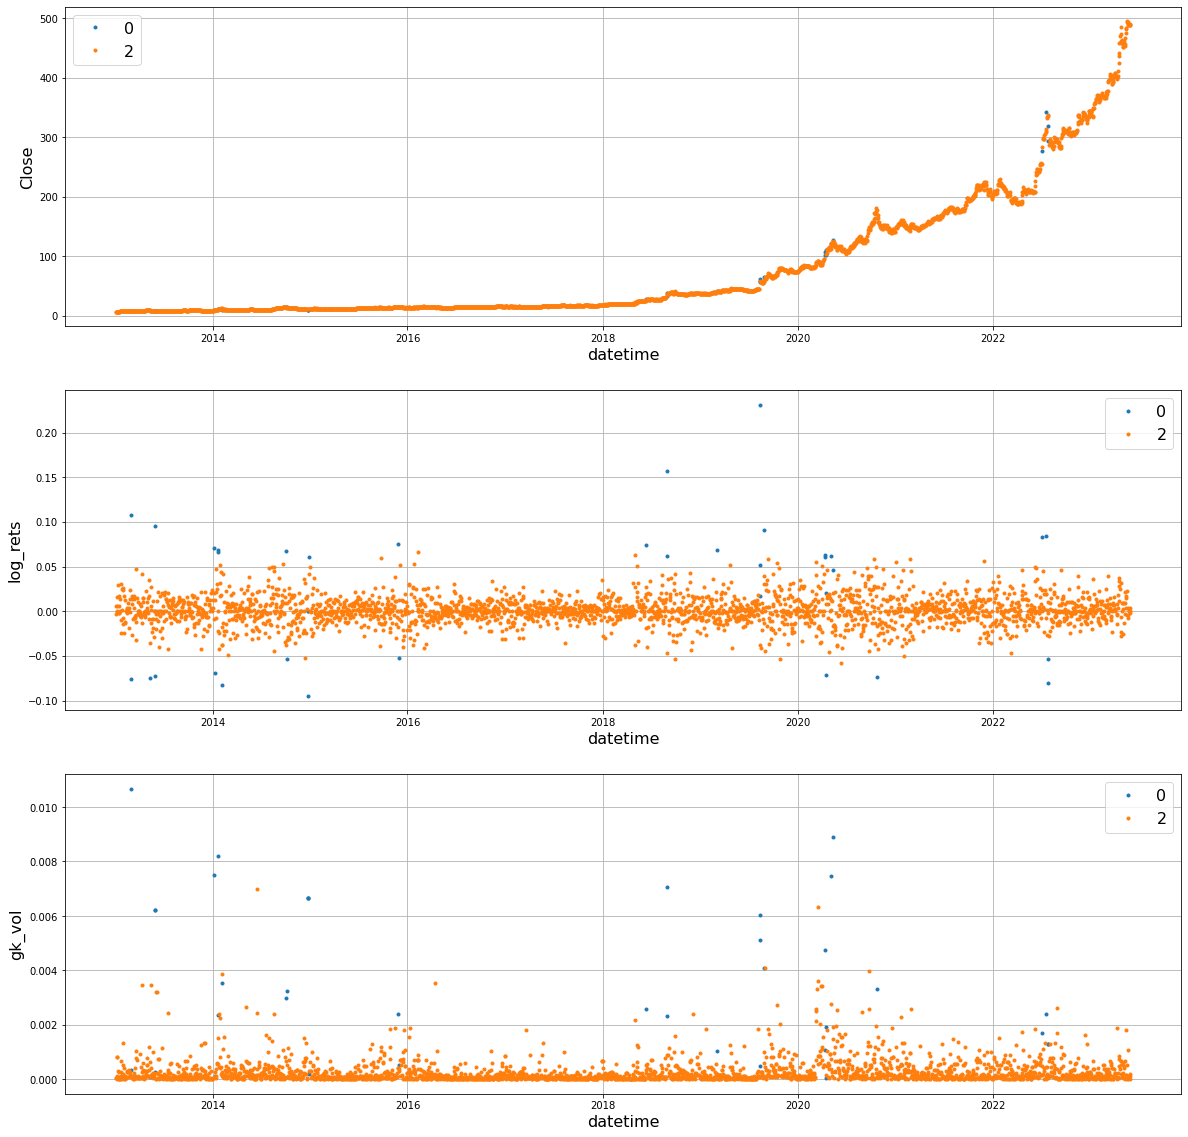

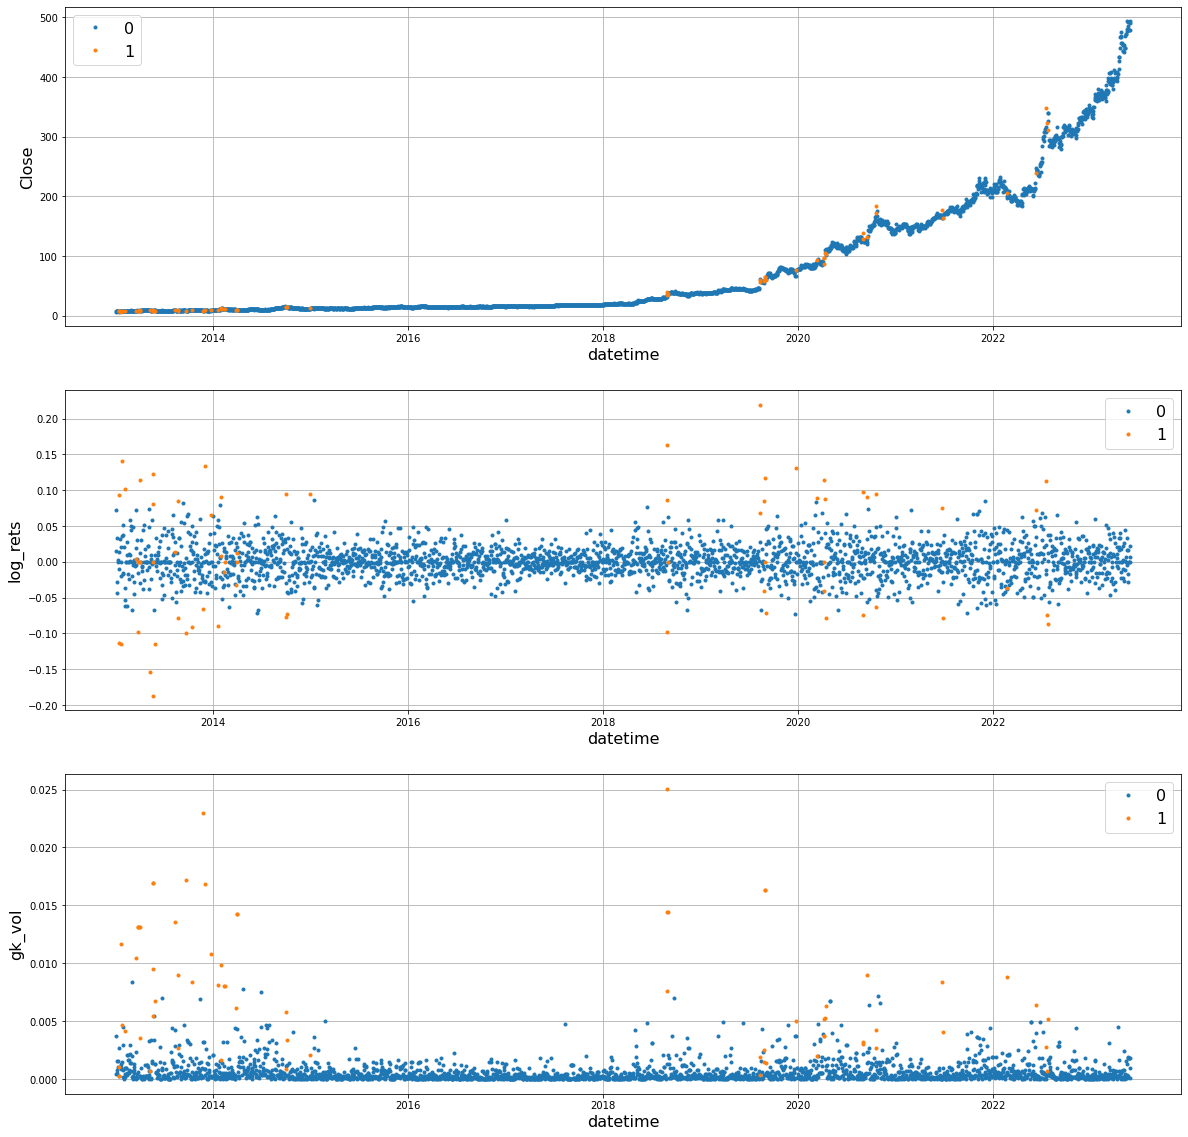

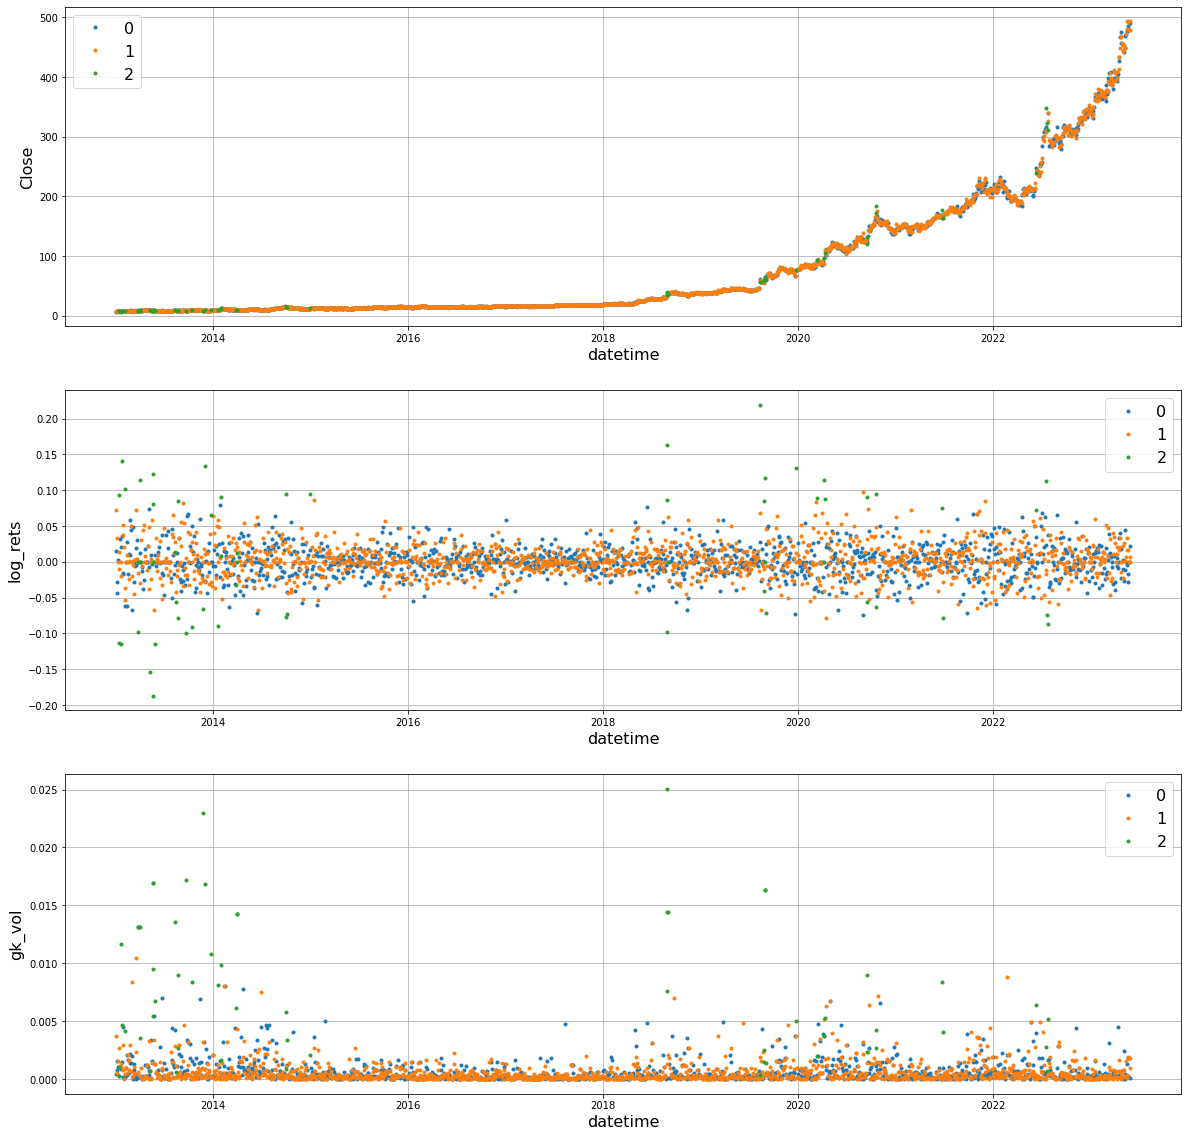

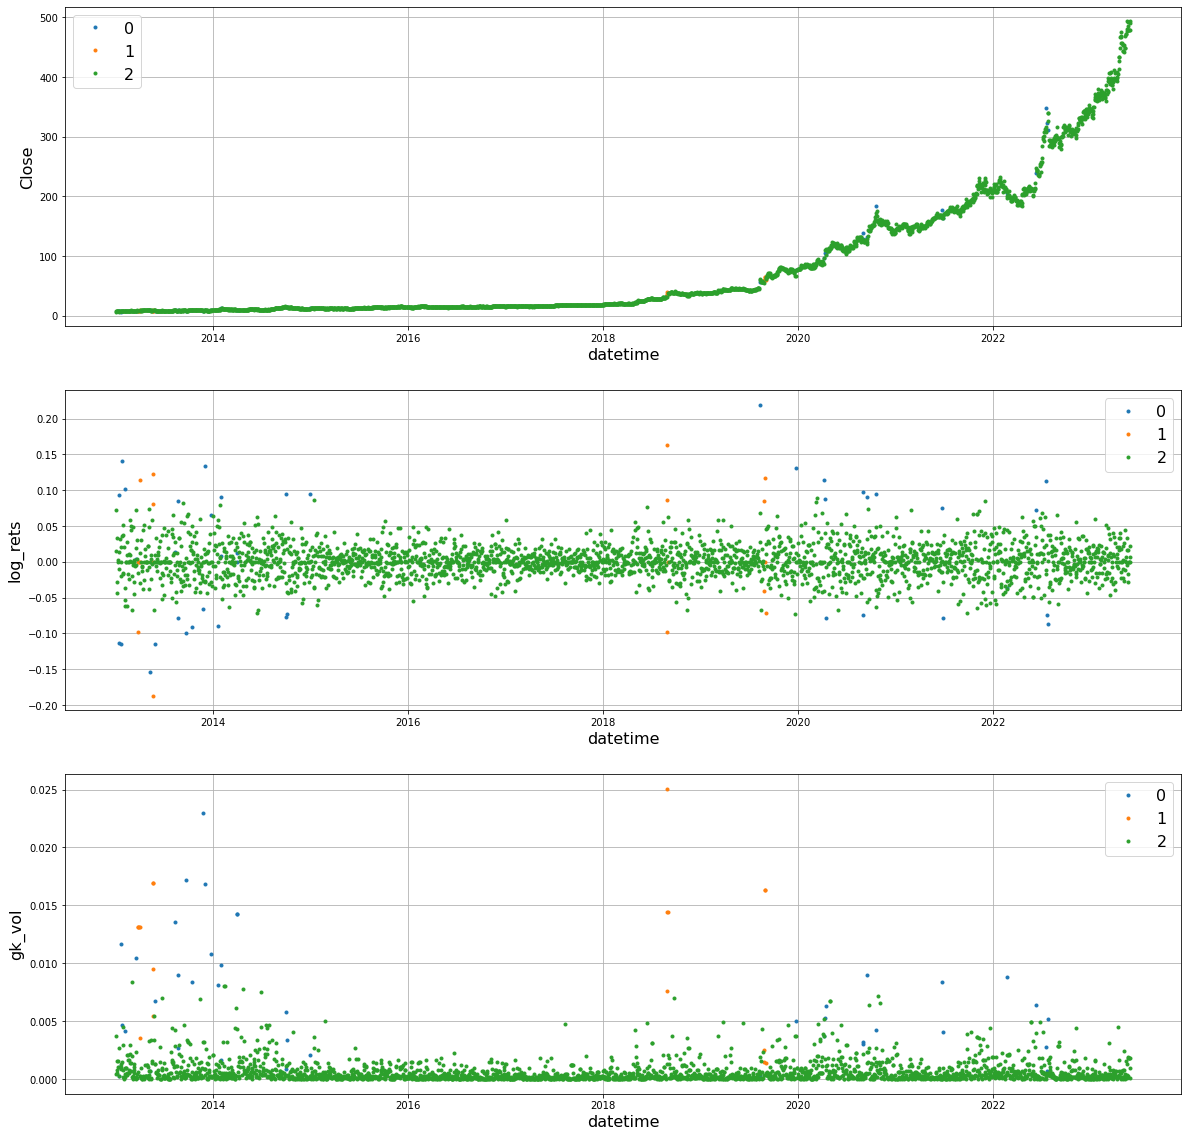

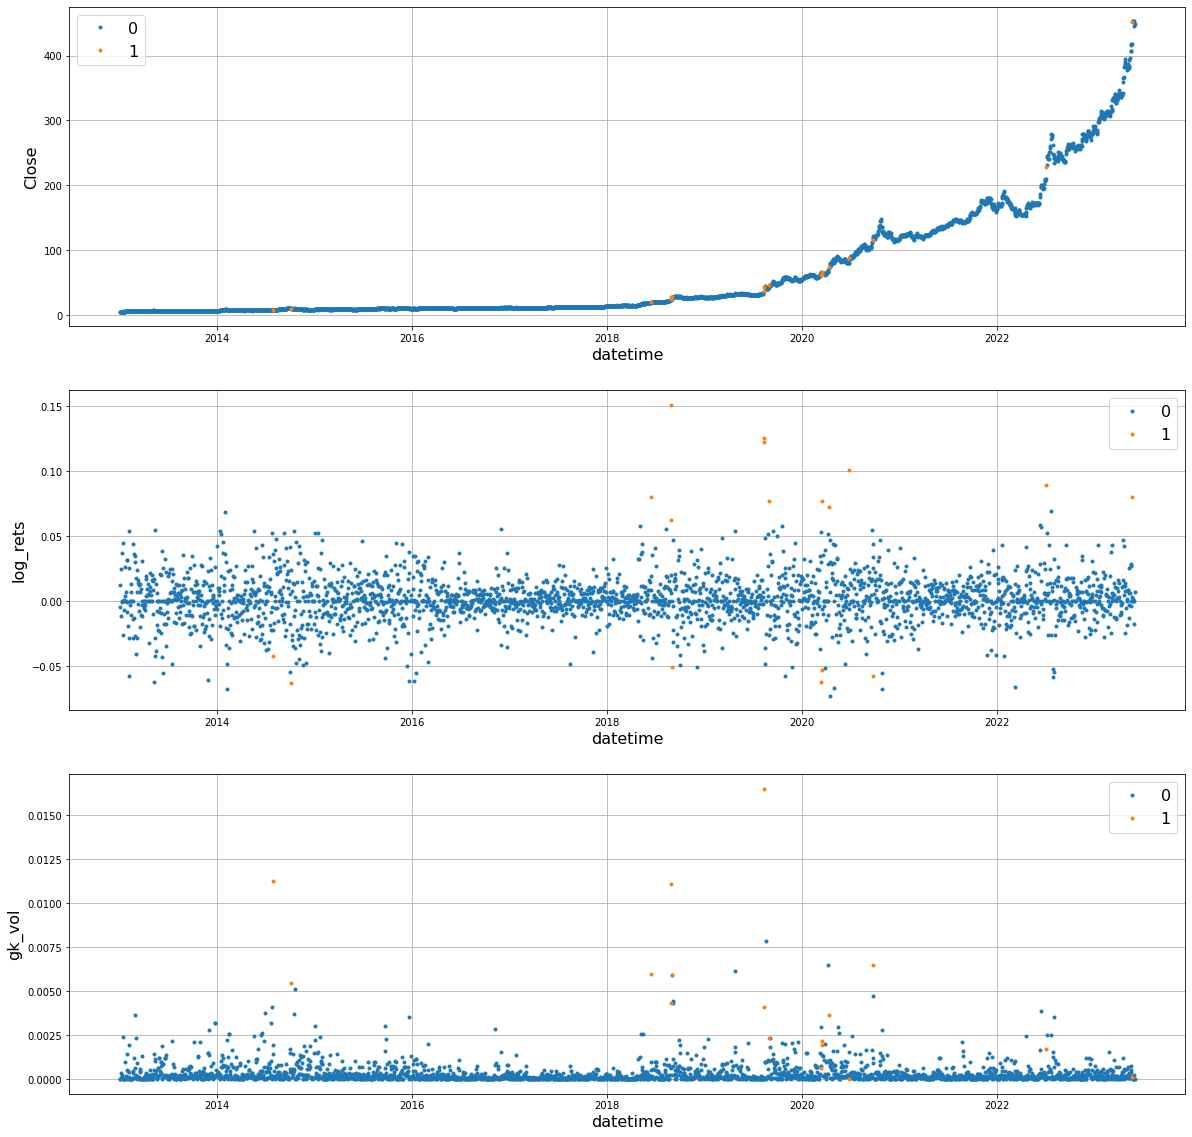

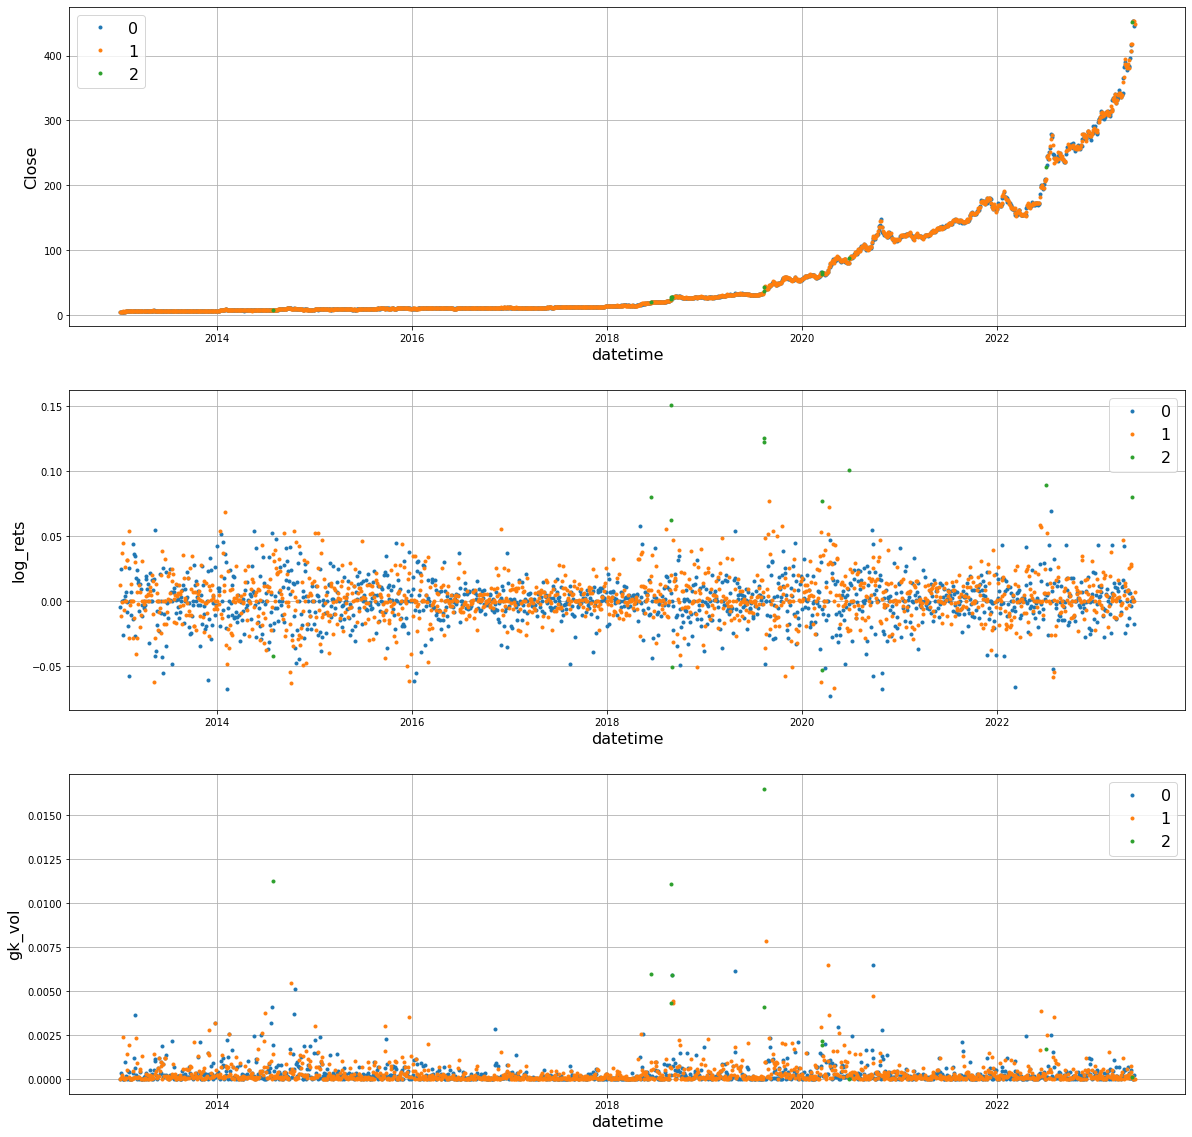

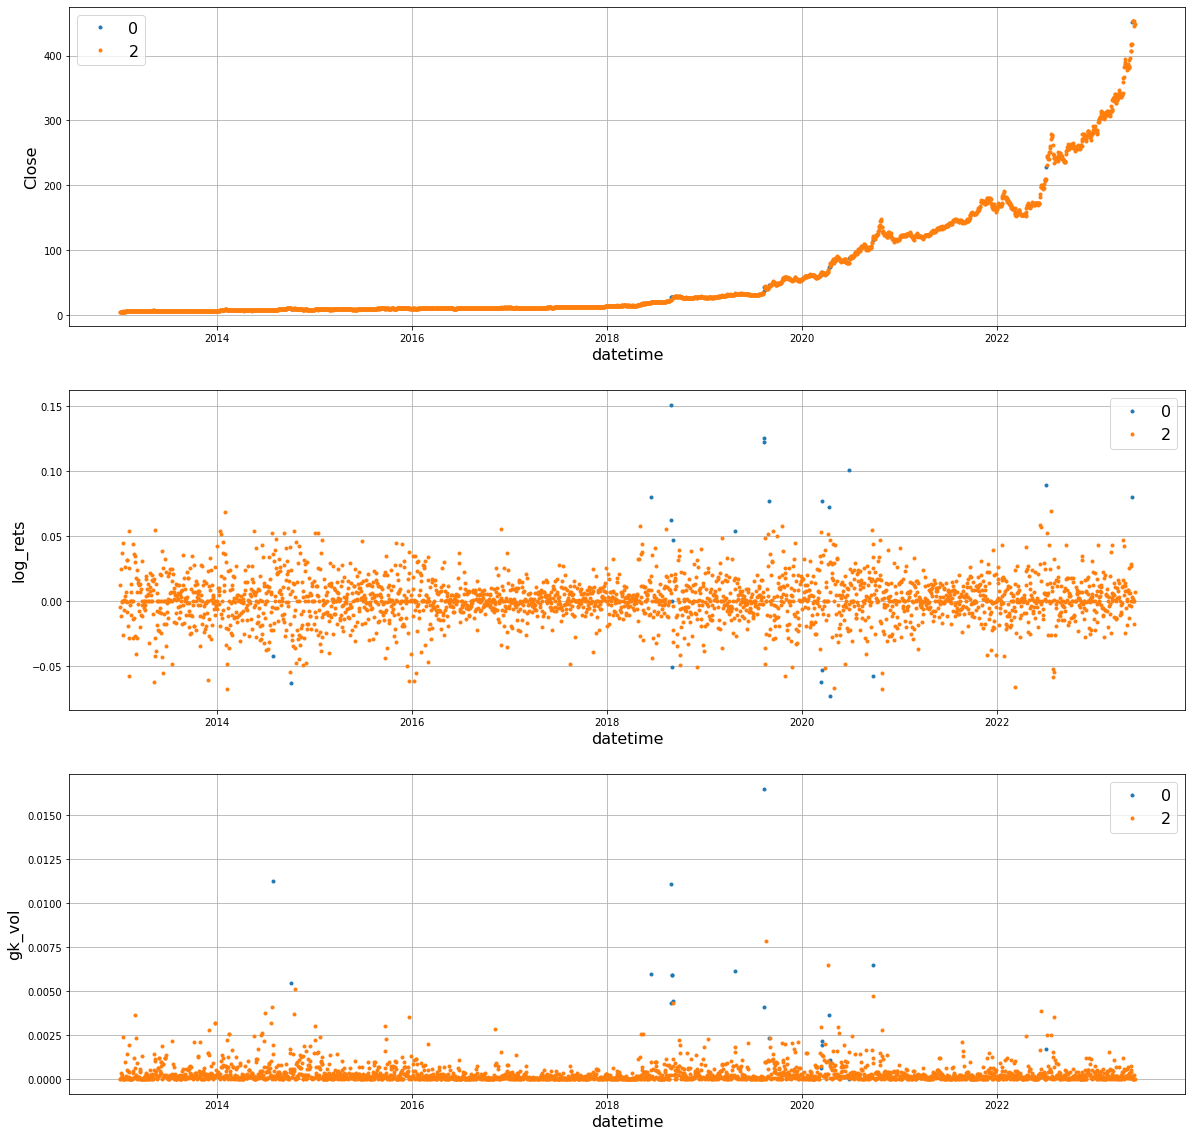

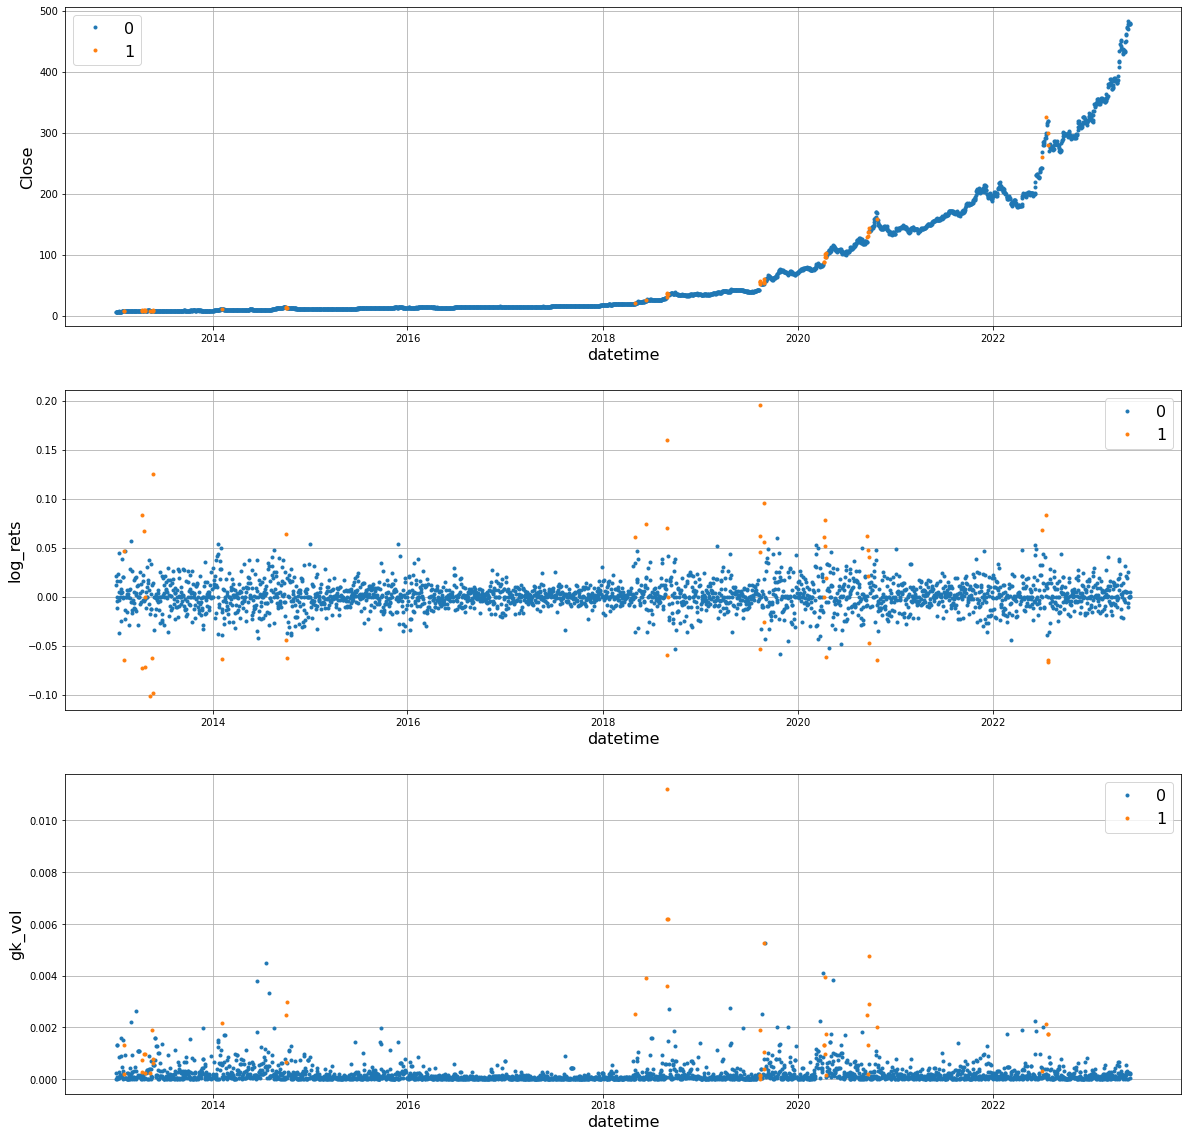

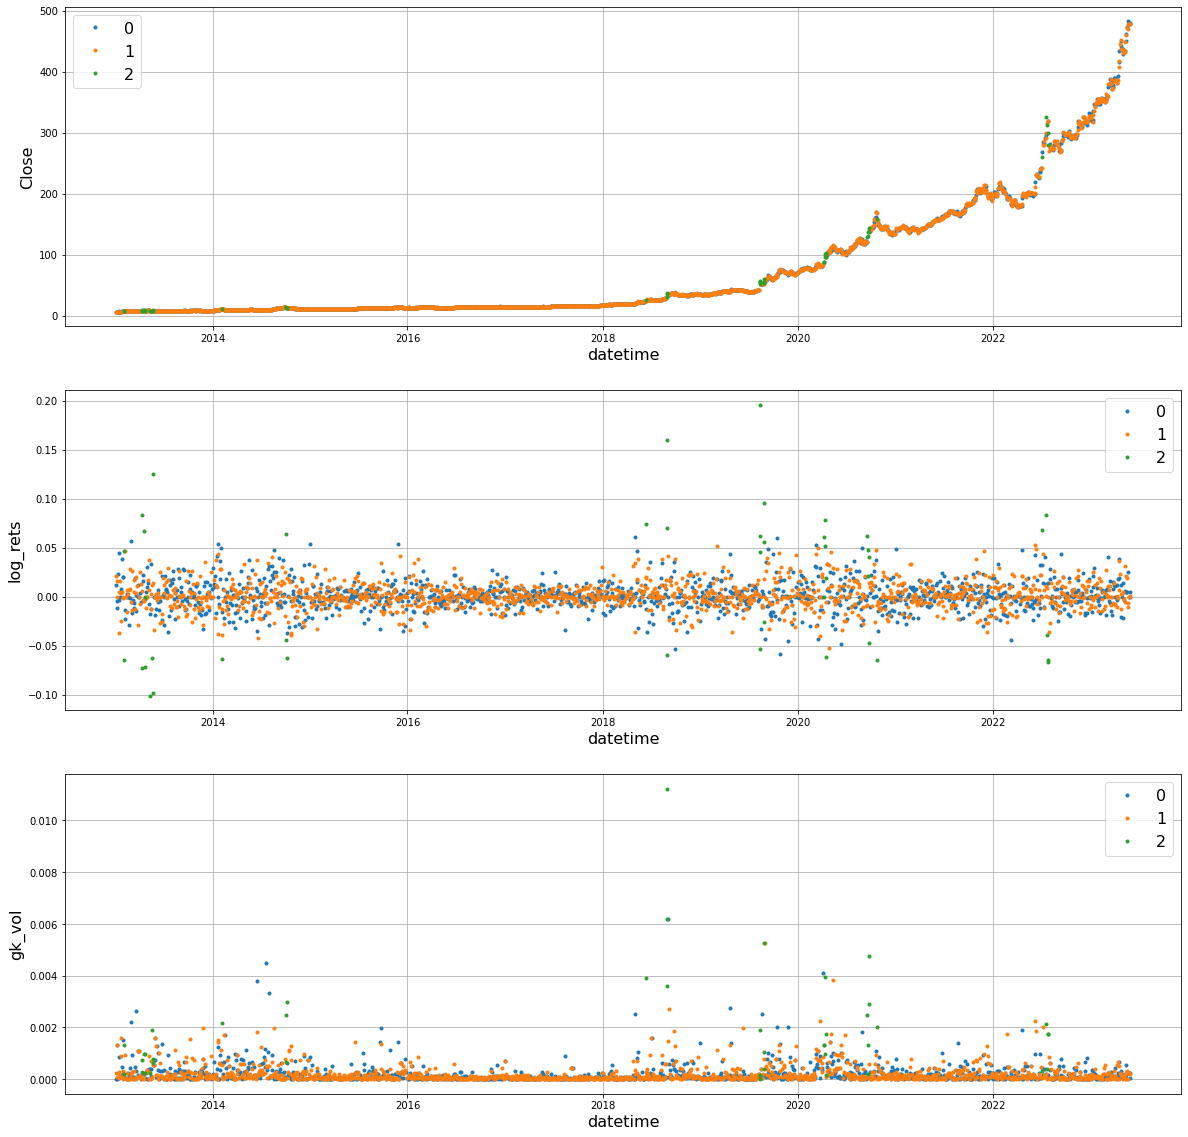

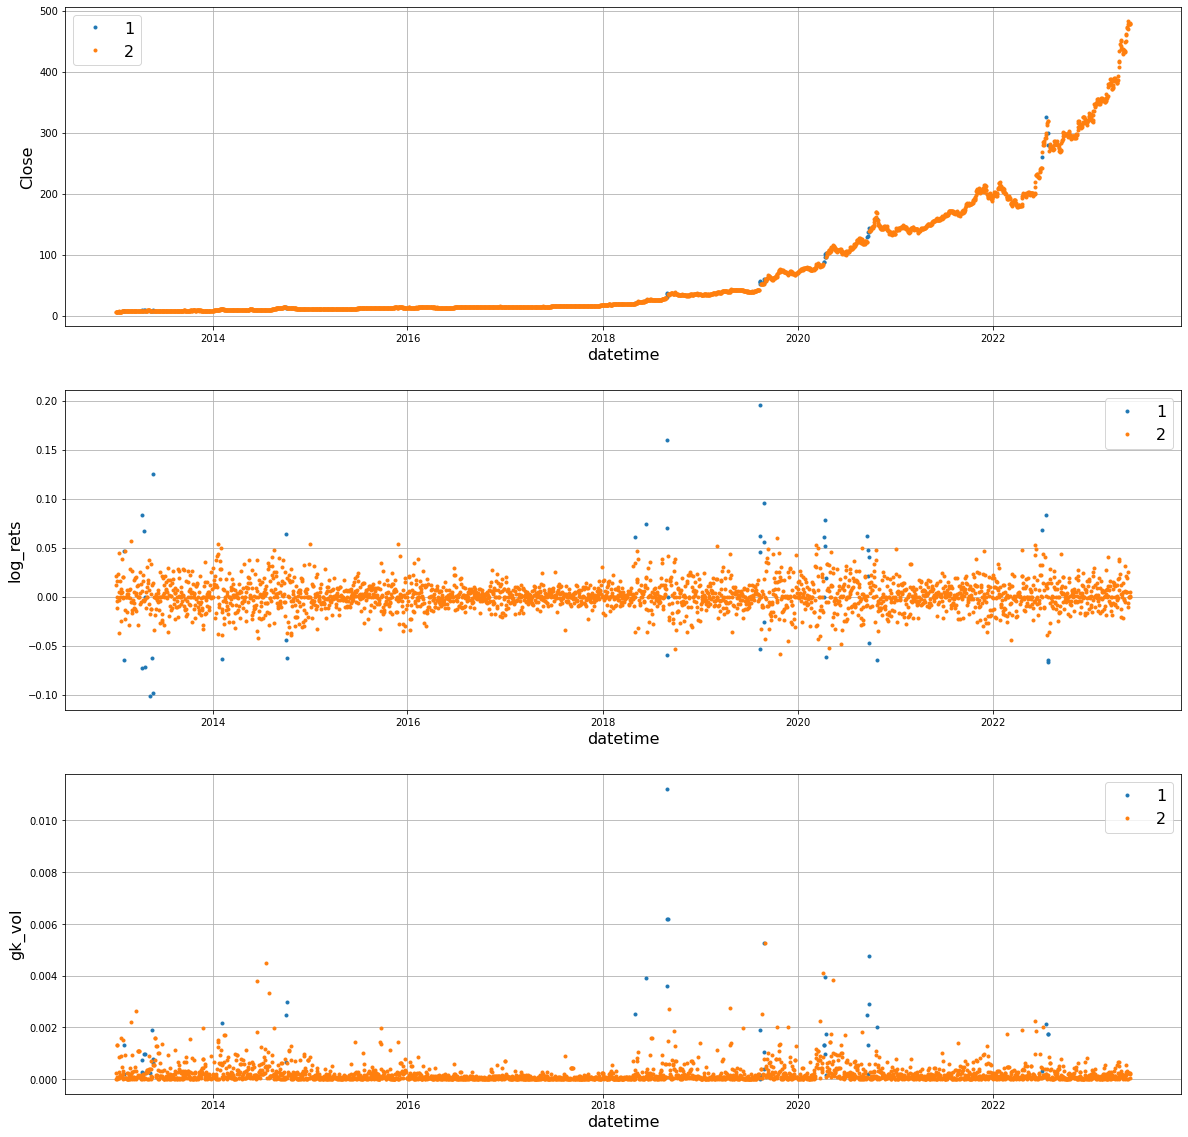

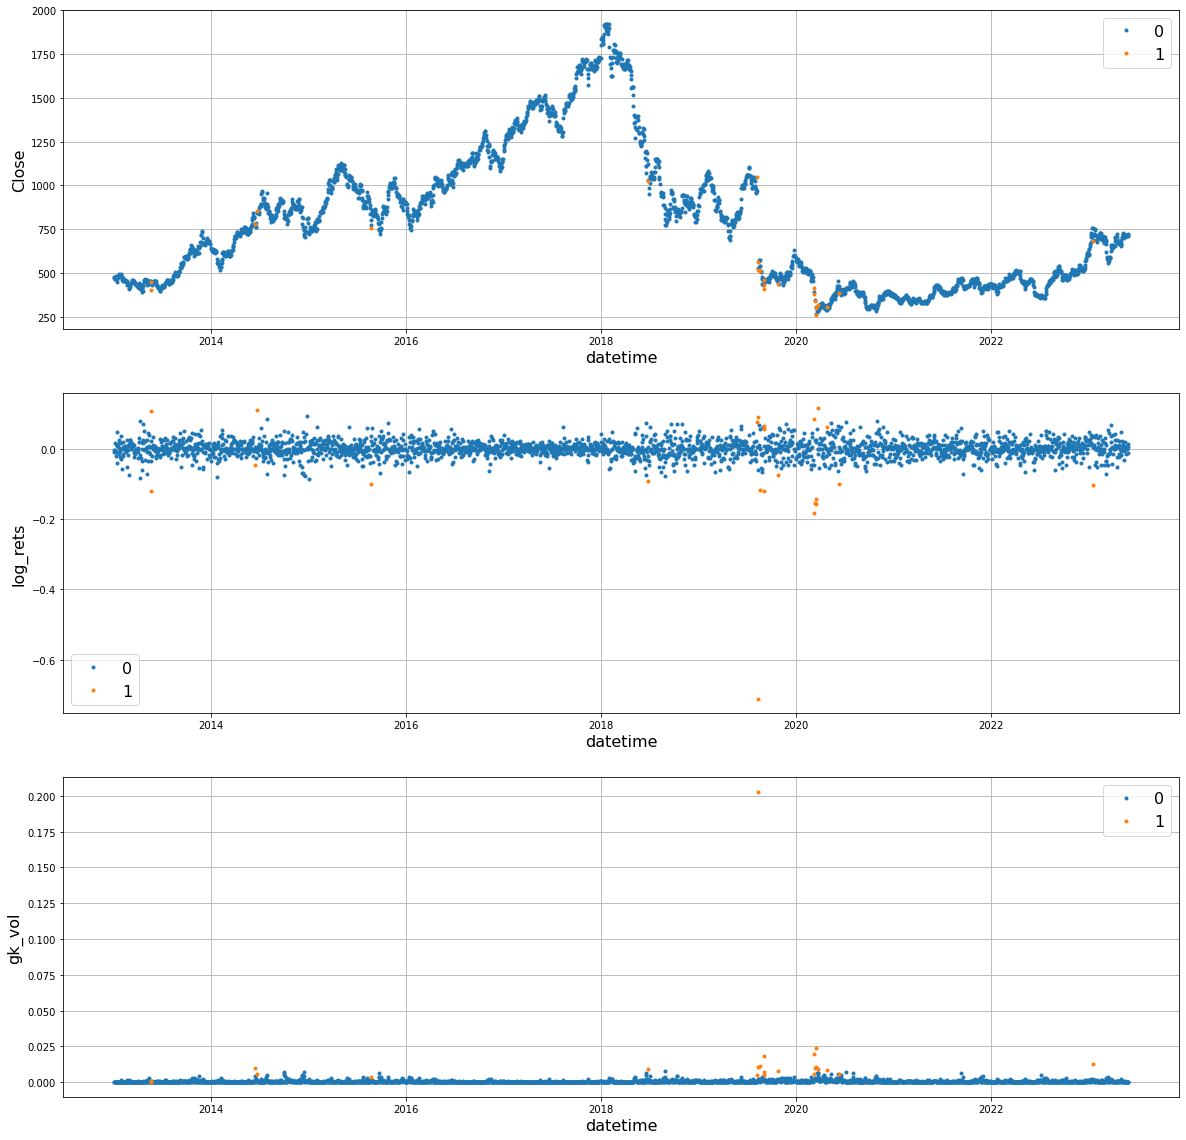

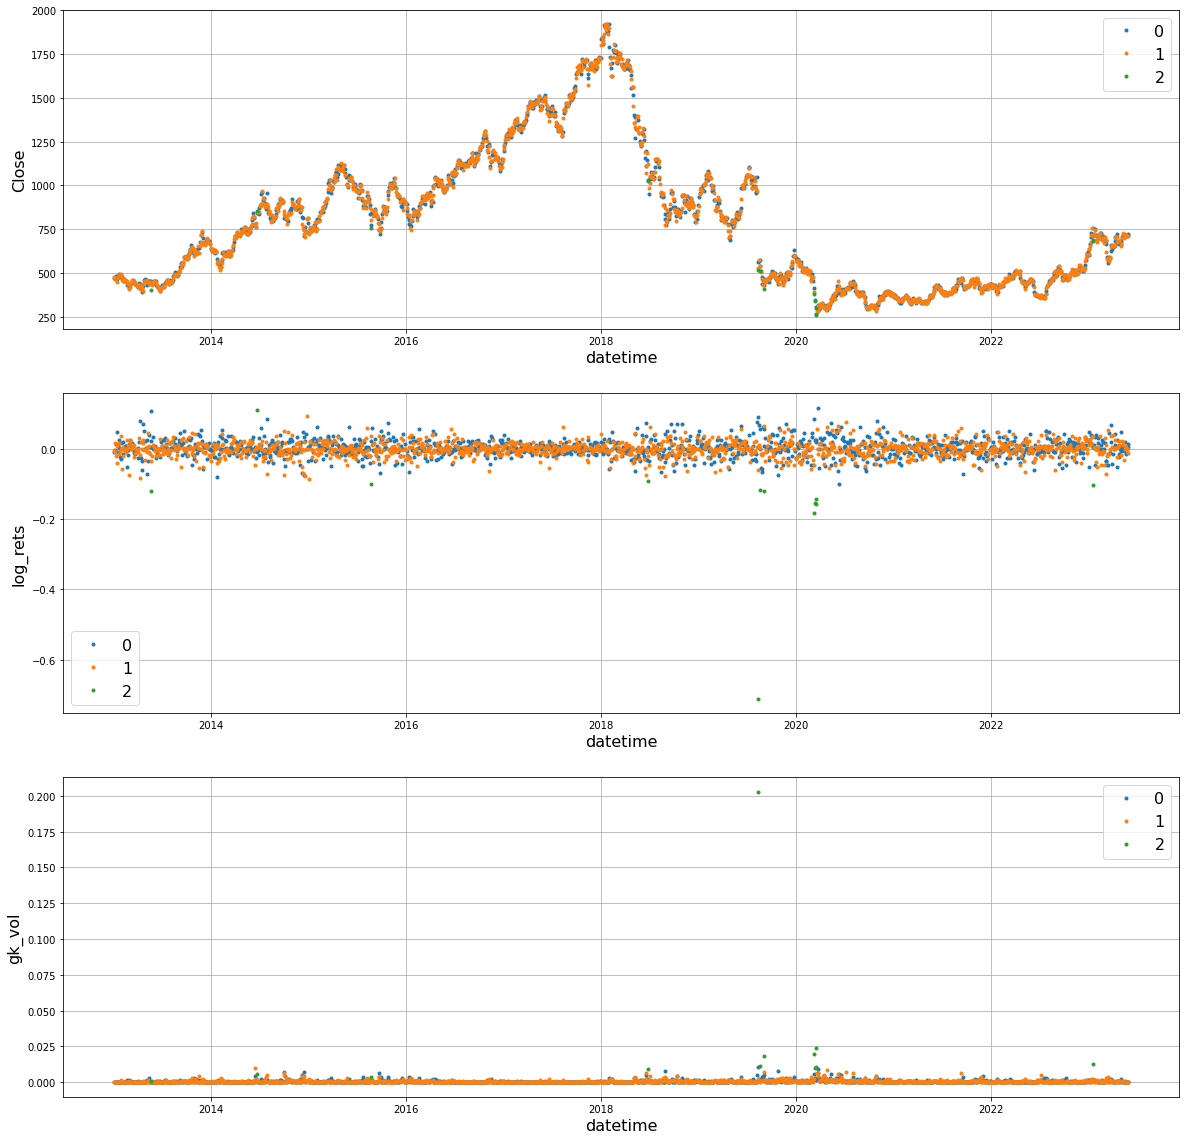

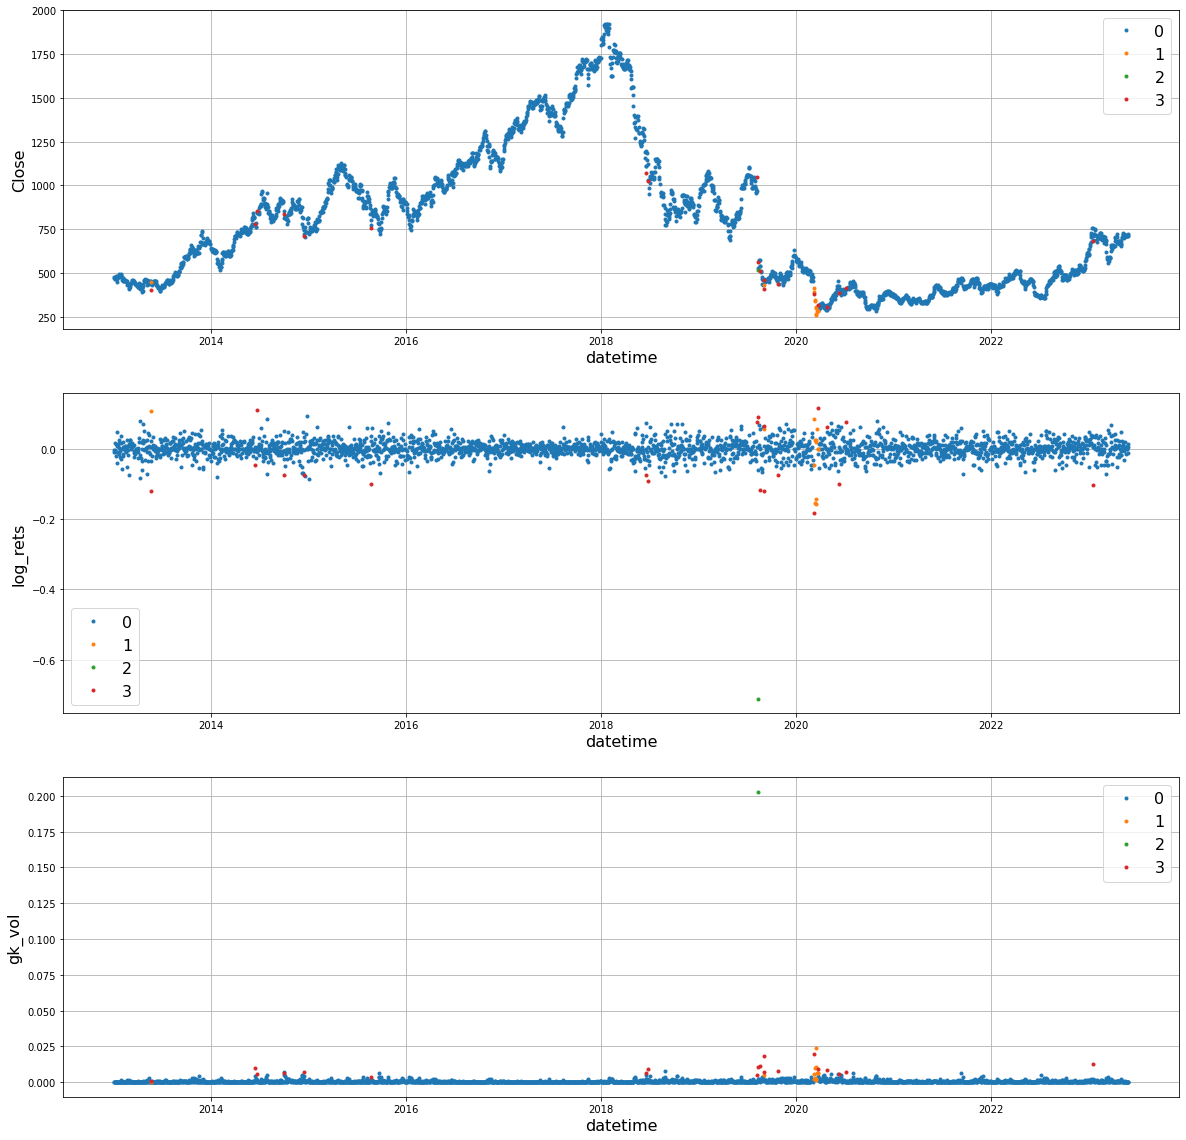

In [79]:
for key in data.keys():
    for comp in comps:
        plot_close_rets_vol(data, key, comp)
plt.show()

## HMM Selection

Selecting the Number of States in Hidden Markov Models: Pragmatic Solutions Illustrated Using Animal Movement
https://sci-hub.st/10.1007/s13253-017-0283-8

Posiblemente requiera armar una funcion de chequeo que use model.monitor==True para chequear convergencia del modelo.  
Recien ahi rankear por AIC&BIC

https://hmmlearn.readthedocs.io/en/latest/api.html#hmmlearn.base.ConvergenceMonitor